In [15]:
from config import settings
from hannover_pylon.data import datamodules as dm
from pathlib import Path
from hannover_pylon.modelling.backbone.utils import FromBuffer , CutPSD, NormLayer
import matplotlib.pyplot as plt
from torch import nn 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')


In [17]:
import numpy as np
from pathlib import Path
from torch import nn
freq_axis = np.linspace(0, 825.5, 8197)
columns= ['psd','level','direction']
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)),NormLayer(min_val=-5.46,max_val=4.96))] + [nn.Identity()]*2
query_key = f'''
    SELECT id FROM data
    WHERE date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
    AND corrupted = 0
    AND sensor = "accel"
'''
data_loader = dm.PSDDataModule(db_path= db_path,table_name='data', columns=columns,transform_func=transform_func, query_key=query_key, batch_size=512, return_dict=True, cached=True,num_workers=16)


In [18]:
import sqlite3 
import pandas as pd
import torch
con = sqlite3.connect(db_path) 
query = f'''
    SELECT * FROM data
    WHERE date BETWEEN "{settings.state.damage5.start}" AND "{settings.state.damage5.end}"
    AND corrupted = 0
    AND sensor = "accel"
    AND level = 1
'''
df = pd.read_sql_query(query, con)

df['psd'] = df['psd'].apply(lambda x: transform_func[0](x))
anoumalous_psd = torch.from_numpy(np.stack(df['psd'].values))

In [19]:
import sqlite3 
import pandas as pd
import torch
con = sqlite3.connect(db_path) 
query = f'''
    SELECT * FROM data
    WHERE date BETWEEN "{settings.state.healthy_test.start}" AND "{settings.state.healthy_test.end}"
    AND corrupted = 0
    AND sensor = "accel"
    AND level = 1
'''
df = pd.read_sql_query(query, con)

df['psd'] = df['psd'].apply(lambda x: transform_func[0](x))
healthy_psd = torch.from_numpy(np.stack(df['psd'].values))

In [20]:
import torch
import torch.nn as nn
from hannover_pylon.modelling.backbone import utils as ut

class OneToOneAutoEncoder(nn.Module):
    def __init__(self, psd_length=1490, hidden_dims=[512, 128, 64], latent_dim=32,
                 activation_str:str ="relu",
                 final_activation:str ="sigmoid"):
        """
        A one-to-one autoencoder for a single sensor.
        
        Args:
            psd_length (int): Length of the PSD vector.
            hidden_dims (list): Hidden layer sizes for the encoder.
            latent_dim (int): Dimension of the latent space.
        """
        super().__init__()
        # Encoder: input (PSD vector) -> hidden layers -> latent vector
        self.encoder = ut.build_layers(
            hidden_dims=[psd_length] + hidden_dims,
            activation_list=[activation_str] * (len(hidden_dims)-1)+[None],
            batch_norm=False,
        )
        self.latent_layer = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder: latent vector -> hidden layers (reverse order) -> reconstruction of PSD vector
        decoder_dims = hidden_dims[::-1]
        self.decoder = ut.build_layers(
            hidden_dims=[latent_dim] + decoder_dims + [psd_length],
            activation_list=[activation_str] * (len(decoder_dims)) + [final_activation],
            batch_norm=False,
        )
        self.device_ = None
        
    def forward(self, x_dict):
        """
        Args:
            x_dict (dict): Dictionary containing the input data under key "psd".  
                           Expected shape of x_dict["psd"]: (B, psd_length)
        
        Returns:
            dict: Contains keys:
                - "reconstruction": the reconstructed PSD vector (B, psd_length)
                - "latent": the latent vector (B, latent_dim)
        """
        # Extract the PSD vector from the dict.
        x = x_dict["psd"]
        # to device 
        if self.device_ is None :
            self.device_ = next(self.parameters()).device
        x = x.to(self.device_)
        encoded = self.encoder(x)
        latent = self.latent_layer(encoded)
        reconstruction = self.decoder(latent)
        return {"reconstruction": reconstruction, "latent": latent}
    
import pytorch_lightning as pl

class OneToOneTrainingModule(pl.LightningModule):
    def __init__(self, psd_length=1490, hidden_dims=[512,128,64], latent_dim=32,
                 activation_str:str ="relu",
                 final_activation:str ="sigmoid", lr=1e-3):
        super().__init__()
        self.model = OneToOneAutoEncoder(psd_length=psd_length, hidden_dims=hidden_dims, latent_dim=latent_dim,
                                         activation_str=activation_str, final_activation=final_activation)
        self.loss_fn = nn.MSELoss()
        self.lr = lr
        self.save_hyperparameters(ignore="model")
        
    def forward(self, x):
        return self.model(x)
    def _common_step(self, batch, batch_idx):
        output = self(batch)
        reconstruction = output["reconstruction"]
        loss = self.loss_fn(reconstruction, batch["psd"])
        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self._common_step(batch, batch_idx)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    def validation_step(self, batch, batch_idx):
        loss = self._common_step(batch, batch_idx)
        self.log("val_loss", loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [21]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch


def run_train(max_epochs=150,hidden_dims=[512,256,128], latent_dim=4, activation_str="relu", final_activation="sigmoid", lr=1e-3):  
    model = OneToOneTrainingModule(
        psd_length=1490,
        hidden_dims=hidden_dims,
        latent_dim=latent_dim,
        activation_str=activation_str,
        final_activation=final_activation,
        lr=lr
    )

    # Define a model checkpoint callback to save the best models.
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',              # Monitor the validation loss.
        dirpath='checkpoints',           # Directory to save checkpoints.
        filename='autoencoder-{epoch:02d}-{val_loss:.4f}', 
        save_top_k=3,                    # Save the 3 best models.
        mode='min'
    )

    # Define an early stopping callback (optional).
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=True,
        mode='min'
    )

    # Create the Trainer instance.
    trainer = Trainer(
        max_epochs=max_epochs,
        callbacks=[checkpoint_callback, early_stop_callback],
        accelerator='gpu'
    )

    # Start training.
    trainer.fit(model,data_loader)
    best_model_path = checkpoint_callback.best_model_path
    best_model = OneToOneTrainingModule.load_from_checkpoint(best_model_path)
    best_score = checkpoint_callback.best_model_score
    best_model.eval()
    # get logger
    return best_model, best_score, best_model_path
    


In [22]:
best_model , best_score,_ = run_train(1,hidden_dims=[512,256,128],
                                    latent_dim=4, 
                                    activation_str="relu",
                                    final_activation="sigmoid",
                                    lr=1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 1.9 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.431     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 84.03it/s, v_num=292, train_loss=0.00145, val_loss=0.00144]

Metric val_loss improved. New best score: 0.001
`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 82.35it/s, v_num=292, train_loss=0.00145, val_loss=0.00144]


In [23]:
import torch
import torch.nn as nn

class Detector(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()  # Set the model to evaluation mode
        self.device = next(model.parameters()).device

    def mse(self, x_dict):
        # Ensure the input tensor is on the same device as the model.
        x = x_dict["psd"].to(self.device)
        with torch.no_grad():
            # The autoencoder returns a dict; we extract the reconstruction.
            out = self.model({"psd": x})
        x_hat = out["reconstruction"]
        
        # Compute the element-wise squared error.
        error = (x - x_hat) ** 2
        
        # Compute the 90th quantile along the feature dimension (dim=1).
        quantile_error = torch.quantile(error, q=0.9, dim=1)
        return quantile_error

    def forward(self, x_dict):
        return self.mse(x_dict)

In [24]:
detector = Detector(best_model)

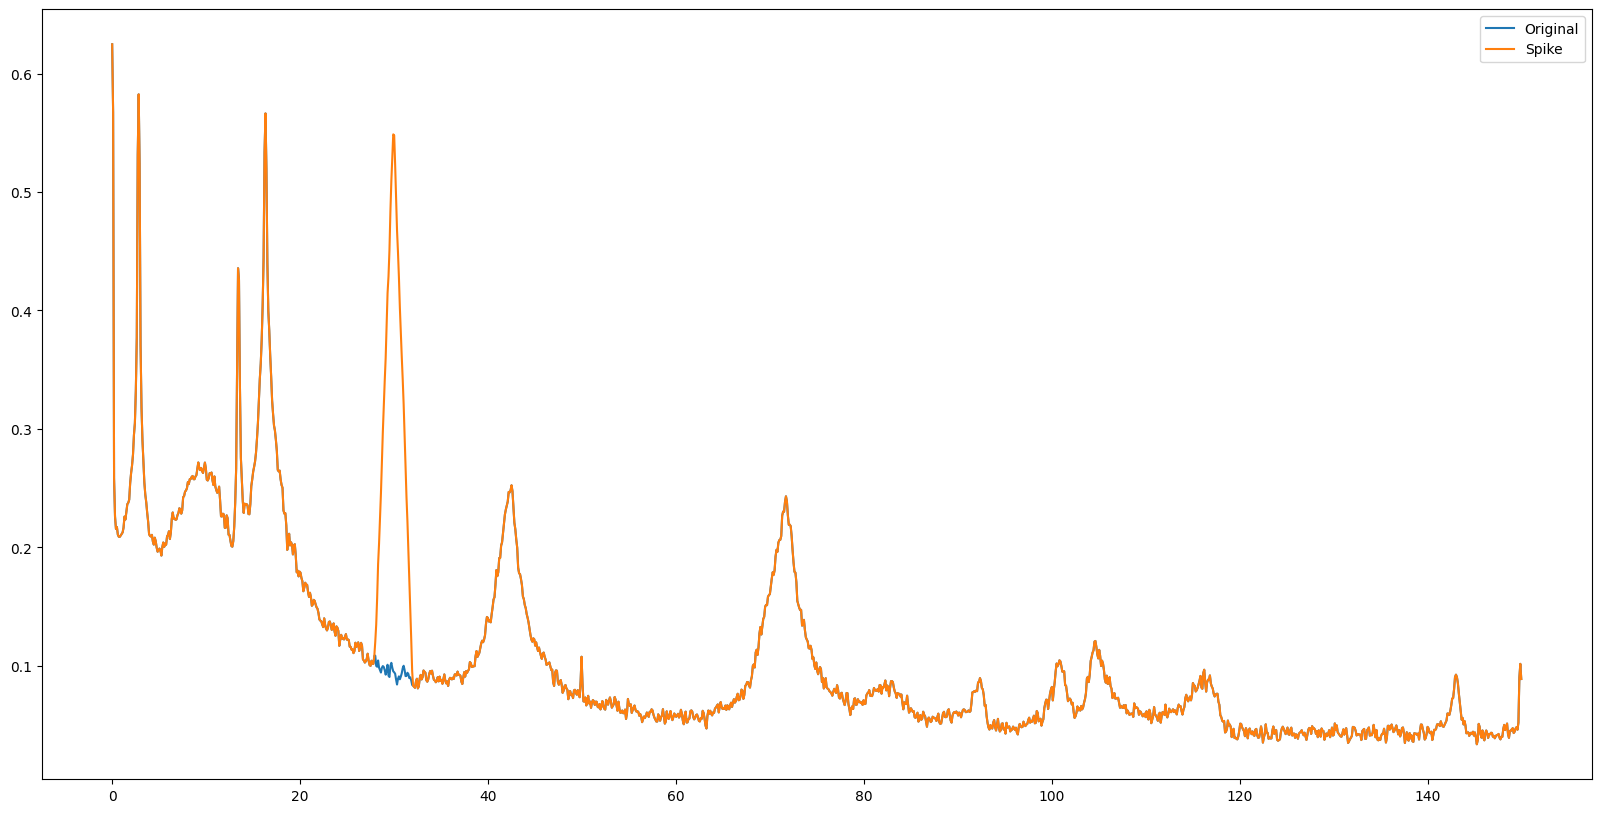

In [25]:
import virtual_anomaly as va
window_center= 30
amplitude = 0.5
psd_aff = va.AddSpike(freq_axis[0:1490],window_center,2,amplitude)(healthy_psd).T
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(freq_axis[0:1490],healthy_psd[0],label='Original')
ax.plot(freq_axis[0:1490],psd_aff[0],label='Spike')
ax.legend()

        



In [26]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
amplitudes = np.arange(-0.5,0.5,0.1)
# arround the amplitude to  2 decimal
amplitudes = np.round(amplitudes,2)
window_centers = np.arange(0,150,2)
df_va_list = []
healthy_score = detector({'psd':healthy_psd}).cpu().numpy()
real_anomaly_score = detector({'psd':anoumalous_psd}).cpu().numpy()
labels = np.array([1] * len(healthy_score) + [0] * len(real_anomaly_score))
scores = np.concatenate([real_anomaly_score, healthy_score])
aucs_real_anomaly = roc_auc_score(labels, scores)

for amplitude in tqdm(amplitudes):
    for window_center in window_centers:
        psd_aff = va.AddSpike(freq_axis[0:1490],window_center,2,amplitude)(healthy_psd).T
        affected_score = detector({'psd':psd_aff}).cpu().numpy()
        labels = np.array([1] * len(healthy_score) + [0] * len(affected_score))
        scores = np.concatenate([affected_score, healthy_score])
        aucs_res = roc_auc_score(labels, scores)
        df_va_list.append({'amplitude':amplitude,'window_center':window_center,'auc':aucs_res})
        df_va = pd.DataFrame(df_va_list)
        # minmum value of auc is 0.1
        df_va['auc'] = df_va['auc'].apply(lambda x: max(0.1,x))
        harmonic_mean = len(df_va['auc'])/np.sum(1/df_va['auc'])
        

100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


In [27]:
aucs_real_anomaly

np.float64(0.560062951297416)

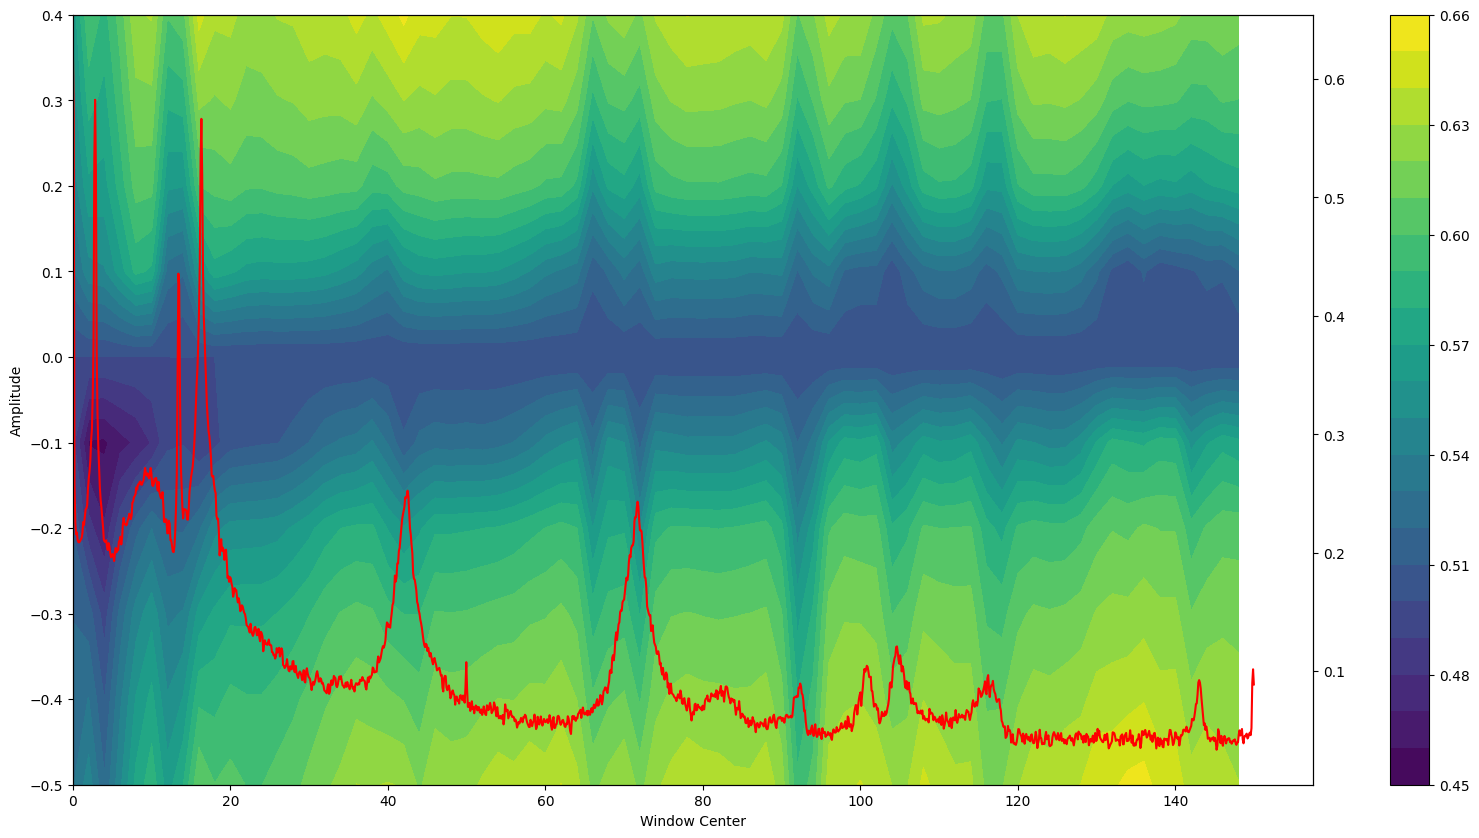

In [28]:
df_va = pd.DataFrame(df_va)
import seaborn as sns
heat = df_va.pivot_table(index='amplitude',columns='window_center',values='auc')
x,y = np.meshgrid(window_centers,amplitudes)
z = heat.values
fig,ax = plt.subplots(1,1,figsize=(20,10))
contour = ax.contourf(x,y,z,cmap='viridis',levels=20)
ax.set_xlabel('Window Center')
ax.set_ylabel('Amplitude')
fig.colorbar(contour, ax=ax)
ax1 = ax.twinx()
ax1.plot(freq_axis[0:1490],healthy_psd[0],label='Spike',color='red')

In [29]:
import numpy as np

# Ensure there are no zero values in 'auc' to avoid division by zero errors
if (df_va['auc'] == 0).any():
    raise ValueError("Zero value found in 'auc'; harmonic mean is undefined.")

# Compute the harmonic mean manually
harmonic_mean_manual = len(df_va['auc']) / np.sum(1 / df_va['auc'])
print("Harmonic Mean (Manual):", harmonic_mean_manual)


Harmonic Mean (Manual): 0.5763046822134558


In [30]:
# -- tuning -- 

In [31]:
def evaluate_on_real_anomalies(detector):
    # Evaluate on your real anomaly dataset:
    real_scores = detector({'psd': anoumalous_psd}).cpu().numpy()
    healthy_scores = detector({'psd': healthy_psd}).cpu().numpy()
    
    # Here, label 1 indicates healthy and 0 indicates anomaly.
    labels = np.array([1] * len(healthy_scores) + [0] * len(real_scores))
    scores = np.concatenate([real_scores, healthy_scores])
    aucs_real_anomaly = roc_auc_score(labels, scores)
    return aucs_real_anomaly

In [32]:
def evaluate_on_virtual_anomalies(detector):
    # Define a grid for virtual anomalies.
    amplitudes = np.round(np.arange(-0.5, 0.5, 0.1), 2)
    window_centers = np.arange(0, 150, 2)
    aucs_va_list = []
    healthy_scores = detector({'psd': healthy_psd}).cpu().numpy()
    for amplitude in amplitudes:
        for window_center in window_centers:
            psd_aff = va.AddSpike(freq_axis[0:1490], window_center, 2, amplitude)(healthy_psd).T
            affected_scores = detector({'psd': psd_aff}).cpu().numpy()
            labels = np.array([1] * len(healthy_psd) + [0] * len(affected_scores))
            scores = np.concatenate([affected_scores, healthy_scores])
            auc_va = roc_auc_score(labels, scores)
            auc_va = max(auc_va, 0.1)  # avoid division by zero
            aucs_va_list.append(auc_va)
    
    harmonic_mean_va = len(aucs_va_list) / np.sum([1 / auc for auc in aucs_va_list])
    return harmonic_mean_va

In [ ]:
import optuna
import mlflow

def objective(trial: optuna.Trial) -> float:
    """
    Optuna objective function that explores variable-depth autoencoder architectures
    and logs results to MLflow.
    """
    # Let Optuna choose the number of hidden layers
    n_layers = trial.suggest_int("n_layers", 2, 4)
    
    # Construct the hidden_dims list based on the chosen number of layers
    hidden_dims = [
        trial.suggest_categorical(f"hidden_dim_{i}", [128, 256, 512, 1024, 2048])
        for i in range(n_layers)
    ]
    
    # Other hyperparameters
    latent_dim = trial.suggest_int("latent_dim", 4, 200, step=1)
    lr = 1e-3
    activation_str = trial.suggest_categorical("activation_str", ["relu", "leakyrelu", "tanh"])
    final_activation = trial.suggest_categorical("final_activation", ["sigmoid", "tanh",None])
    

    # Collect hyperparameters into a dictionary
    hparams = {
        "n_layers": n_layers,
        "hidden_dims": hidden_dims,
        "latent_dim": latent_dim,
        "lr": lr,
    }

    # Start an MLflow run for logging (nested=True if part of a larger run)
    with mlflow.start_run():
        mlflow.log_params(hparams)

        # Train the model with the chosen hyperparameters
        best_model_module, best_model_score, best_model_path = run_train(
            hidden_dims=hidden_dims,
            latent_dim=latent_dim,
            lr=lr,
            activation_str=activation_str,
            final_activation=final_activation,
        )

        # Wrap the trained model in the Detector for evaluation
        detector = Detector(best_model_module.model)

        # Evaluate on real anomalies and virtual anomalies
        aucs_real = evaluate_on_real_anomalies(detector)
        harmonic_mean_va = evaluate_on_virtual_anomalies(detector)

        # Log relevant metrics
        mlflow.log_metric("aucs_real_anomaly", aucs_real)
        mlflow.log_metric("harmonic_mean_va", harmonic_mean_va)
        mlflow.log_metric("best_score", best_model_score)
        
        # Optionally log the best checkpoint path as an artifact
        mlflow.log_artifact(best_model_path)

        # Store the real anomaly metric for later reference
        trial.set_user_attr("aucs_real_anomaly", aucs_real)

        # Return the harmonic mean of VA AUCs as the metric to maximize
        return harmonic_mean_va


# Create and run the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60)

# Display the best trial's results
print("Best trial:")
best_trial = study.best_trial
print(f"  Harmonic Mean (VA): {best_trial.value}")
print("  Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")
print("  Real Anomaly AUC:", best_trial.user_attrs.get("aucs_real_anomaly"))


[I 2025-02-19 14:35:13,952] A new study created in memory with name: no-name-14f3bc0a-c263-44cb-84dc-07cec6747bfe


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 1.7 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.652     Total estimated model params size (MB)
10        Modules in train mode
2         Modules in eval mode


DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 85.61it/s, v_num=299, train_loss=0.000452, val_loss=0.000465]

Metric val_loss improved. New best score: 0.000


Epoch 1: 100%|██████████| 247/247 [00:04<00:00, 59.39it/s, v_num=299, train_loss=0.000274, val_loss=0.000277]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 64.98it/s, v_num=299, train_loss=0.000193, val_loss=0.000179]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 62.03it/s, v_num=299, train_loss=0.00016, val_loss=0.000168] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 63.14it/s, v_num=299, train_loss=0.000183, val_loss=0.000157]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 62.37it/s, v_num=299, train_loss=0.000129, val_loss=0.000139]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 62.67it/s, v_num=299, train_loss=0.000125, val_loss=0.000121]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 63.98it/s, v_num=299, train_loss=0.000109, val_loss=0.000118]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 63.84it/s, v_num=299, train_loss=0.000107, val_loss=0.000112]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 62.76it/s, v_num=299, train_loss=0.0001, val_loss=0.000111]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 63.36it/s, v_num=299, train_loss=9.61e-5, val_loss=0.000106] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:04<00:00, 61.58it/s, v_num=299, train_loss=0.00011, val_loss=0.000105] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 64.10it/s, v_num=299, train_loss=0.000104, val_loss=0.000104]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 65.29it/s, v_num=299, train_loss=9.65e-5, val_loss=0.000101] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 62.36it/s, v_num=299, train_loss=9.13e-5, val_loss=0.000101] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 65.60it/s, v_num=299, train_loss=0.000105, val_loss=9.9e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 63.69it/s, v_num=299, train_loss=8.88e-5, val_loss=9.78e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 64.22it/s, v_num=299, train_loss=8.02e-5, val_loss=9.51e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 63.35it/s, v_num=299, train_loss=0.000115, val_loss=9.46e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 64.56it/s, v_num=299, train_loss=7.98e-5, val_loss=9.16e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 63.78it/s, v_num=299, train_loss=8.63e-5, val_loss=9.1e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 63.74it/s, v_num=299, train_loss=9.07e-5, val_loss=9.09e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 247/247 [00:03<00:00, 62.43it/s, v_num=299, train_loss=8.59e-5, val_loss=9.01e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 49: 100%|██████████| 247/247 [00:03<00:00, 64.39it/s, v_num=299, train_loss=8.83e-5, val_loss=8.86e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 50: 100%|██████████| 247/247 [00:03<00:00, 63.56it/s, v_num=299, train_loss=8.57e-5, val_loss=8.85e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 54: 100%|██████████| 247/247 [00:03<00:00, 63.06it/s, v_num=299, train_loss=8.8e-5, val_loss=8.75e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 61: 100%|██████████| 247/247 [00:03<00:00, 63.60it/s, v_num=299, train_loss=9.82e-5, val_loss=8.65e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 63: 100%|██████████| 247/247 [00:03<00:00, 64.62it/s, v_num=299, train_loss=7.42e-5, val_loss=8.58e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 66: 100%|██████████| 247/247 [00:03<00:00, 64.48it/s, v_num=299, train_loss=7.73e-5, val_loss=8.53e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 72: 100%|██████████| 247/247 [00:03<00:00, 64.76it/s, v_num=299, train_loss=8.77e-5, val_loss=8.4e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 81: 100%|██████████| 247/247 [00:03<00:00, 63.76it/s, v_num=299, train_loss=8.77e-5, val_loss=8.39e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 84: 100%|██████████| 247/247 [00:03<00:00, 65.04it/s, v_num=299, train_loss=7.33e-5, val_loss=8.32e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 85: 100%|██████████| 247/247 [00:03<00:00, 64.75it/s, v_num=299, train_loss=7.94e-5, val_loss=8.32e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 89: 100%|██████████| 247/247 [00:03<00:00, 64.88it/s, v_num=299, train_loss=8.3e-5, val_loss=8.23e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 93: 100%|██████████| 247/247 [00:03<00:00, 63.87it/s, v_num=299, train_loss=8e-5, val_loss=8.23e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 94: 100%|██████████| 247/247 [00:03<00:00, 62.37it/s, v_num=299, train_loss=7.75e-5, val_loss=8.19e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 104: 100%|██████████| 247/247 [00:03<00:00, 63.69it/s, v_num=299, train_loss=7.59e-5, val_loss=8.2e-5]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 104: 100%|██████████| 247/247 [00:03<00:00, 62.91it/s, v_num=299, train_loss=7.59e-5, val_loss=8.2e-5]


[I 2025-02-19 14:42:14,241] Trial 0 finished with value: 0.8352152840338818 and parameters: {'n_layers': 2, 'hidden_dim_0': 512, 'hidden_dim_1': 128, 'latent_dim': 13, 'activation_str': 'leakyrelu', 'final_activation': 'tanh'}. Best is trial 0 with value: 0.8352152840338818.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 9.5 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
9.5 M     Trainable params
0         Non-trainable

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:04<00:00, 59.95it/s, v_num=300, train_loss=0.00127, val_loss=0.00131]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:04<00:00, 50.65it/s, v_num=300, train_loss=0.000827, val_loss=0.000738]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:04<00:00, 49.46it/s, v_num=300, train_loss=0.000491, val_loss=0.000498]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:04<00:00, 50.30it/s, v_num=300, train_loss=0.00032, val_loss=0.000325] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:05<00:00, 48.32it/s, v_num=300, train_loss=0.000238, val_loss=0.00025] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:05<00:00, 49.36it/s, v_num=300, train_loss=0.000179, val_loss=0.000208]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:04<00:00, 50.16it/s, v_num=300, train_loss=0.000182, val_loss=0.000179]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:04<00:00, 50.95it/s, v_num=300, train_loss=0.000164, val_loss=0.000169]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:07<00:00, 34.29it/s, v_num=300, train_loss=0.00016, val_loss=0.000162] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:05<00:00, 46.34it/s, v_num=300, train_loss=0.000157, val_loss=0.000156]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:05<00:00, 47.56it/s, v_num=300, train_loss=0.000164, val_loss=0.000155]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:05<00:00, 47.78it/s, v_num=300, train_loss=0.000127, val_loss=0.000133]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:05<00:00, 46.35it/s, v_num=300, train_loss=0.000132, val_loss=0.000132]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:04<00:00, 49.44it/s, v_num=300, train_loss=0.000122, val_loss=0.000126]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:05<00:00, 46.02it/s, v_num=300, train_loss=0.000109, val_loss=0.00012] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:05<00:00, 47.02it/s, v_num=300, train_loss=0.000126, val_loss=0.000142]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 25: 100%|██████████| 247/247 [00:05<00:00, 47.00it/s, v_num=300, train_loss=0.000126, val_loss=0.000142]


[I 2025-02-19 14:44:49,381] Trial 1 finished with value: 0.7966933212576525 and parameters: {'n_layers': 3, 'hidden_dim_0': 1024, 'hidden_dim_1': 2048, 'hidden_dim_2': 512, 'latent_dim': 136, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 0 with value: 0.8352152840338818.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 1.7 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
1.7 M     Trainable params
0   

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:03<00:00, 79.21it/s, v_num=302, train_loss=0.00138, val_loss=0.00135]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:04<00:00, 60.76it/s, v_num=302, train_loss=0.0012, val_loss=0.00111] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:04<00:00, 60.87it/s, v_num=302, train_loss=0.000771, val_loss=0.000757]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:04<00:00, 60.40it/s, v_num=302, train_loss=0.000587, val_loss=0.000605]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 4: 100%|██████████| 247/247 [00:04<00:00, 60.49it/s, v_num=302, train_loss=0.000556, val_loss=0.000555]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 5: 100%|██████████| 247/247 [00:04<00:00, 61.13it/s, v_num=302, train_loss=0.00041, val_loss=0.000431] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 62.59it/s, v_num=302, train_loss=0.000363, val_loss=0.000364]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:04<00:00, 61.72it/s, v_num=302, train_loss=0.000301, val_loss=0.000318]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 62.91it/s, v_num=302, train_loss=0.000311, val_loss=0.000293]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:04<00:00, 60.45it/s, v_num=302, train_loss=0.000221, val_loss=0.000258]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:04<00:00, 54.49it/s, v_num=302, train_loss=0.000206, val_loss=0.000226]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:04<00:00, 58.71it/s, v_num=302, train_loss=0.000233, val_loss=0.000221]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 61.92it/s, v_num=302, train_loss=0.000204, val_loss=0.000198]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:04<00:00, 60.91it/s, v_num=302, train_loss=0.000193, val_loss=0.000198]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:04<00:00, 59.59it/s, v_num=302, train_loss=0.000216, val_loss=0.000196]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:04<00:00, 58.92it/s, v_num=302, train_loss=0.000195, val_loss=0.000176]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:04<00:00, 60.12it/s, v_num=302, train_loss=0.000149, val_loss=0.000158]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:04<00:00, 57.22it/s, v_num=302, train_loss=0.000132, val_loss=0.000153]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:04<00:00, 61.00it/s, v_num=302, train_loss=0.000138, val_loss=0.000144]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:04<00:00, 60.69it/s, v_num=302, train_loss=0.000132, val_loss=0.000144]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 62.42it/s, v_num=302, train_loss=0.000128, val_loss=0.000136]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:04<00:00, 59.92it/s, v_num=302, train_loss=0.000111, val_loss=0.000133]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:04<00:00, 60.02it/s, v_num=302, train_loss=0.000131, val_loss=0.000128]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:04<00:00, 59.54it/s, v_num=302, train_loss=0.000111, val_loss=0.00012] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:04<00:00, 61.01it/s, v_num=302, train_loss=0.000118, val_loss=0.000119]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 62.38it/s, v_num=302, train_loss=0.000111, val_loss=0.000113]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:04<00:00, 61.73it/s, v_num=302, train_loss=0.000106, val_loss=0.000109]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:04<00:00, 59.87it/s, v_num=302, train_loss=0.000108, val_loss=0.000109]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:04<00:00, 59.93it/s, v_num=302, train_loss=0.000108, val_loss=0.000102]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:04<00:00, 61.37it/s, v_num=302, train_loss=0.000105, val_loss=9.83e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:04<00:00, 57.60it/s, v_num=302, train_loss=8.65e-5, val_loss=9.68e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:04<00:00, 60.44it/s, v_num=302, train_loss=9.33e-5, val_loss=9.15e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 247/247 [00:04<00:00, 61.09it/s, v_num=302, train_loss=9.81e-5, val_loss=9.02e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 52: 100%|██████████| 247/247 [00:04<00:00, 60.72it/s, v_num=302, train_loss=8.16e-5, val_loss=8.52e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 53: 100%|██████████| 247/247 [00:04<00:00, 60.96it/s, v_num=302, train_loss=7.74e-5, val_loss=8.37e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 57: 100%|██████████| 247/247 [00:04<00:00, 60.54it/s, v_num=302, train_loss=8.2e-5, val_loss=8.31e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 58: 100%|██████████| 247/247 [00:03<00:00, 62.65it/s, v_num=302, train_loss=8e-5, val_loss=8.22e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 59: 100%|██████████| 247/247 [00:04<00:00, 59.62it/s, v_num=302, train_loss=7.94e-5, val_loss=8.04e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 60: 100%|██████████| 247/247 [00:04<00:00, 61.44it/s, v_num=302, train_loss=8.37e-5, val_loss=7.95e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 61: 100%|██████████| 247/247 [00:03<00:00, 61.87it/s, v_num=302, train_loss=7.63e-5, val_loss=7.71e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 64: 100%|██████████| 247/247 [00:04<00:00, 61.69it/s, v_num=302, train_loss=7.61e-5, val_loss=7.51e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 67: 100%|██████████| 247/247 [00:04<00:00, 61.59it/s, v_num=302, train_loss=6.58e-5, val_loss=7.47e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 69: 100%|██████████| 247/247 [00:04<00:00, 61.12it/s, v_num=302, train_loss=7.38e-5, val_loss=7.29e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 70: 100%|██████████| 247/247 [00:03<00:00, 61.89it/s, v_num=302, train_loss=7.2e-5, val_loss=7.2e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 75: 100%|██████████| 247/247 [00:03<00:00, 63.01it/s, v_num=302, train_loss=6.67e-5, val_loss=7.17e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 76: 100%|██████████| 247/247 [00:04<00:00, 60.99it/s, v_num=302, train_loss=6.93e-5, val_loss=7.13e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 77: 100%|██████████| 247/247 [00:04<00:00, 60.89it/s, v_num=302, train_loss=7.18e-5, val_loss=7.07e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 81: 100%|██████████| 247/247 [00:03<00:00, 61.93it/s, v_num=302, train_loss=6.13e-5, val_loss=6.85e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 91: 100%|██████████| 247/247 [00:04<00:00, 60.89it/s, v_num=302, train_loss=6.74e-5, val_loss=7.13e-5]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 91: 100%|██████████| 247/247 [00:04<00:00, 60.87it/s, v_num=302, train_loss=6.74e-5, val_loss=7.13e-5]


[I 2025-02-19 14:51:16,500] Trial 2 finished with value: 0.8384534497904316 and parameters: {'n_layers': 3, 'hidden_dim_0': 512, 'hidden_dim_1': 128, 'hidden_dim_2': 128, 'latent_dim': 103, 'activation_str': 'leakyrelu', 'final_activation': 'sigmoid'}. Best is trial 2 with value: 0.8384534497904316.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 1.0 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
1.0 M     Trainable param

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:04<00:00, 49.92it/s, v_num=303, train_loss=0.010, val_loss=0.0107]

Metric val_loss improved. New best score: 0.011


Epoch 1: 100%|██████████| 247/247 [00:06<00:00, 40.85it/s, v_num=303, train_loss=0.00145, val_loss=0.00151]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.002


Epoch 2: 100%|██████████| 247/247 [00:04<00:00, 61.43it/s, v_num=303, train_loss=0.00152, val_loss=0.00143]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 4: 100%|██████████| 247/247 [00:04<00:00, 60.29it/s, v_num=303, train_loss=0.00155, val_loss=0.00141]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 7: 100%|██████████| 247/247 [00:04<00:00, 59.96it/s, v_num=303, train_loss=0.00151, val_loss=0.00139]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 8: 100%|██████████| 247/247 [00:04<00:00, 60.71it/s, v_num=303, train_loss=0.00114, val_loss=0.00104] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 9: 100%|██████████| 247/247 [00:04<00:00, 59.73it/s, v_num=303, train_loss=0.000825, val_loss=0.000853]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 10: 100%|██████████| 247/247 [00:04<00:00, 58.43it/s, v_num=303, train_loss=0.000731, val_loss=0.000728]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 11: 100%|██████████| 247/247 [00:04<00:00, 59.47it/s, v_num=303, train_loss=0.000609, val_loss=0.000617]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 12: 100%|██████████| 247/247 [00:04<00:00, 59.79it/s, v_num=303, train_loss=0.000569, val_loss=0.000577]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 13: 100%|██████████| 247/247 [00:04<00:00, 60.88it/s, v_num=303, train_loss=0.00042, val_loss=0.000537] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 14: 100%|██████████| 247/247 [00:04<00:00, 60.00it/s, v_num=303, train_loss=0.000505, val_loss=0.000483]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:04<00:00, 61.33it/s, v_num=303, train_loss=0.000376, val_loss=0.000399]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:04<00:00, 60.20it/s, v_num=303, train_loss=0.000369, val_loss=0.000345]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:04<00:00, 61.32it/s, v_num=303, train_loss=0.000349, val_loss=0.000314]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 63.38it/s, v_num=303, train_loss=0.00022, val_loss=0.000277] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:04<00:00, 60.07it/s, v_num=303, train_loss=0.000241, val_loss=0.000258]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:04<00:00, 61.39it/s, v_num=303, train_loss=0.000242, val_loss=0.00025] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:04<00:00, 60.17it/s, v_num=303, train_loss=0.000234, val_loss=0.000238]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:04<00:00, 61.33it/s, v_num=303, train_loss=0.00021, val_loss=0.000235] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:04<00:00, 61.52it/s, v_num=303, train_loss=0.000241, val_loss=0.000221]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 63.77it/s, v_num=303, train_loss=0.000206, val_loss=0.000199]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 62.87it/s, v_num=303, train_loss=0.000205, val_loss=0.000199]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 61.81it/s, v_num=303, train_loss=0.000186, val_loss=0.000194]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:04<00:00, 61.00it/s, v_num=303, train_loss=0.000174, val_loss=0.000169]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 62.74it/s, v_num=303, train_loss=0.00018, val_loss=0.000164] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:04<00:00, 61.39it/s, v_num=303, train_loss=0.000151, val_loss=0.000153]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:04<00:00, 60.94it/s, v_num=303, train_loss=0.000148, val_loss=0.000146]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 62.13it/s, v_num=303, train_loss=0.000139, val_loss=0.000145]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 247/247 [00:04<00:00, 61.58it/s, v_num=303, train_loss=0.000132, val_loss=0.000138]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:04<00:00, 61.24it/s, v_num=303, train_loss=0.000119, val_loss=0.000137]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 49: 100%|██████████| 247/247 [00:03<00:00, 61.97it/s, v_num=303, train_loss=0.000138, val_loss=0.000134]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 51: 100%|██████████| 247/247 [00:04<00:00, 60.81it/s, v_num=303, train_loss=0.000133, val_loss=0.000131]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 55: 100%|██████████| 247/247 [00:04<00:00, 61.51it/s, v_num=303, train_loss=0.000123, val_loss=0.00013] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 63: 100%|██████████| 247/247 [00:03<00:00, 63.59it/s, v_num=303, train_loss=0.00011, val_loss=0.000127] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 65: 100%|██████████| 247/247 [00:04<00:00, 61.65it/s, v_num=303, train_loss=0.000121, val_loss=0.000123]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 73: 100%|██████████| 247/247 [00:04<00:00, 60.73it/s, v_num=303, train_loss=0.000108, val_loss=0.000121]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 79: 100%|██████████| 247/247 [00:04<00:00, 59.81it/s, v_num=303, train_loss=0.000121, val_loss=0.000121]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 80: 100%|██████████| 247/247 [00:04<00:00, 59.66it/s, v_num=303, train_loss=0.000126, val_loss=0.000119]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 85: 100%|██████████| 247/247 [00:04<00:00, 59.92it/s, v_num=303, train_loss=0.000115, val_loss=0.000117]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 91: 100%|██████████| 247/247 [00:04<00:00, 59.29it/s, v_num=303, train_loss=0.000115, val_loss=0.000116]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 96: 100%|██████████| 247/247 [00:03<00:00, 61.85it/s, v_num=303, train_loss=0.000112, val_loss=0.000115]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 106: 100%|██████████| 247/247 [00:04<00:00, 61.06it/s, v_num=303, train_loss=0.000127, val_loss=0.000117]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 106: 100%|██████████| 247/247 [00:04<00:00, 60.98it/s, v_num=303, train_loss=0.000127, val_loss=0.000117]


[I 2025-02-19 14:58:42,687] Trial 3 finished with value: 0.770087815757573 and parameters: {'n_layers': 3, 'hidden_dim_0': 256, 'hidden_dim_1': 256, 'hidden_dim_2': 256, 'latent_dim': 9, 'activation_str': 'tanh', 'final_activation': 'sigmoid'}. Best is trial 2 with value: 0.8384534497904316.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 3.7 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
3.7 M     Trainable params
0     

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:03<00:00, 80.32it/s, v_num=305, train_loss=0.0375, val_loss=0.0383]

Metric val_loss improved. New best score: 0.038


Epoch 1: 100%|██████████| 247/247 [00:04<00:00, 60.12it/s, v_num=305, train_loss=0.0409, val_loss=0.0383]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.038


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 62.07it/s, v_num=305, train_loss=0.0366, val_loss=0.0388]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.038. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 62.03it/s, v_num=305, train_loss=0.0366, val_loss=0.0388]


[I 2025-02-19 14:59:42,050] Trial 4 finished with value: 0.5057132861353042 and parameters: {'n_layers': 3, 'hidden_dim_0': 1024, 'hidden_dim_1': 256, 'hidden_dim_2': 128, 'latent_dim': 169, 'activation_str': 'relu', 'final_activation': 'sigmoid'}. Best is trial 2 with value: 0.8384534497904316.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0 

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:03<00:00, 75.91it/s, v_num=306, train_loss=0.00129, val_loss=0.00131]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:04<00:00, 60.21it/s, v_num=306, train_loss=0.000537, val_loss=0.000603]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:04<00:00, 61.35it/s, v_num=306, train_loss=0.00038, val_loss=0.000473] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:04<00:00, 60.90it/s, v_num=306, train_loss=0.000262, val_loss=0.000258]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 61.75it/s, v_num=306, train_loss=0.000195, val_loss=0.000214]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:04<00:00, 61.43it/s, v_num=306, train_loss=0.000177, val_loss=0.000184]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:04<00:00, 60.32it/s, v_num=306, train_loss=0.000173, val_loss=0.00016] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:04<00:00, 60.77it/s, v_num=306, train_loss=0.000251, val_loss=0.000247]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 18: 100%|██████████| 247/247 [00:04<00:00, 60.71it/s, v_num=306, train_loss=0.000251, val_loss=0.000247]


[I 2025-02-19 15:01:10,346] Trial 5 finished with value: 0.7386093270281249 and parameters: {'n_layers': 3, 'hidden_dim_0': 256, 'hidden_dim_1': 2048, 'hidden_dim_2': 128, 'latent_dim': 149, 'activation_str': 'leakyrelu', 'final_activation': None}. Best is trial 2 with value: 0.8384534497904316.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 3.7 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
3.7 M     Trainable params
0 

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:03<00:00, 77.10it/s, v_num=307, train_loss=0.00123, val_loss=0.00118]

Metric val_loss improved. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:04<00:00, 57.45it/s, v_num=307, train_loss=0.00066, val_loss=0.000683]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:04<00:00, 61.03it/s, v_num=307, train_loss=0.000459, val_loss=0.000452]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:04<00:00, 60.26it/s, v_num=307, train_loss=0.00031, val_loss=0.000311] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:04<00:00, 60.23it/s, v_num=307, train_loss=0.000283, val_loss=0.000278]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:04<00:00, 59.64it/s, v_num=307, train_loss=0.000215, val_loss=0.000204]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:04<00:00, 61.23it/s, v_num=307, train_loss=0.000215, val_loss=0.000178]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:04<00:00, 60.78it/s, v_num=307, train_loss=0.00014, val_loss=0.000155] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:04<00:00, 60.73it/s, v_num=307, train_loss=0.000177, val_loss=0.000196]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 20: 100%|██████████| 247/247 [00:04<00:00, 59.21it/s, v_num=307, train_loss=0.000177, val_loss=0.000196]


[I 2025-02-19 15:02:52,986] Trial 6 finished with value: 0.7557259696545648 and parameters: {'n_layers': 4, 'hidden_dim_0': 256, 'hidden_dim_1': 512, 'hidden_dim_2': 2048, 'hidden_dim_3': 128, 'latent_dim': 89, 'activation_str': 'leakyrelu', 'final_activation': None}. Best is trial 2 with value: 0.8384534497904316.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 9.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
9.4 M    

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:04<00:00, 61.16it/s, v_num=310, train_loss=0.0115, val_loss=0.0107]

Metric val_loss improved. New best score: 0.011


Epoch 1: 100%|██████████| 247/247 [00:04<00:00, 52.39it/s, v_num=310, train_loss=0.011, val_loss=0.0107]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.011


Epoch 2: 100%|██████████| 247/247 [00:05<00:00, 49.14it/s, v_num=310, train_loss=0.0106, val_loss=0.0107] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.011


Epoch 12: 100%|██████████| 247/247 [00:04<00:00, 51.02it/s, v_num=310, train_loss=0.0119, val_loss=0.0107] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.011. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 247/247 [00:05<00:00, 48.94it/s, v_num=310, train_loss=0.0119, val_loss=0.0107]


[I 2025-02-19 15:04:11,932] Trial 7 finished with value: 0.5078383513779284 and parameters: {'n_layers': 3, 'hidden_dim_0': 2048, 'hidden_dim_1': 512, 'hidden_dim_2': 1024, 'latent_dim': 59, 'activation_str': 'tanh', 'final_activation': 'sigmoid'}. Best is trial 2 with value: 0.8384534497904316.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 3.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
3.3 M     Trainable params
0 

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 85.15it/s, v_num=311, train_loss=0.00215, val_loss=0.00305]

Metric val_loss improved. New best score: 0.003


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 64.27it/s, v_num=311, train_loss=0.00128, val_loss=0.00143]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 63.09it/s, v_num=311, train_loss=0.000908, val_loss=0.000939]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 62.70it/s, v_num=311, train_loss=0.000642, val_loss=0.000636]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 63.23it/s, v_num=311, train_loss=0.000411, val_loss=0.000407]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 62.45it/s, v_num=311, train_loss=0.000315, val_loss=0.000348]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 63.02it/s, v_num=311, train_loss=0.000223, val_loss=0.000231]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 62.29it/s, v_num=311, train_loss=0.000171, val_loss=0.000186]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 62.62it/s, v_num=311, train_loss=0.000181, val_loss=0.000174]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 63.15it/s, v_num=311, train_loss=0.000143, val_loss=0.000161]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 62.82it/s, v_num=311, train_loss=0.000145, val_loss=0.000142]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 62.99it/s, v_num=311, train_loss=0.000139, val_loss=0.000127]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 63.35it/s, v_num=311, train_loss=0.000114, val_loss=0.000116]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 62.54it/s, v_num=311, train_loss=9.82e-5, val_loss=0.000111] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 62.57it/s, v_num=311, train_loss=9.83e-5, val_loss=0.000101] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:04<00:00, 61.37it/s, v_num=311, train_loss=8.72e-5, val_loss=9.81e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 63.02it/s, v_num=311, train_loss=0.0108, val_loss=0.0107]    

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 63.00it/s, v_num=311, train_loss=0.0108, val_loss=0.0107]


[I 2025-02-19 15:06:46,276] Trial 8 finished with value: 0.7991564147817417 and parameters: {'n_layers': 2, 'hidden_dim_0': 1024, 'hidden_dim_1': 128, 'latent_dim': 113, 'activation_str': 'tanh', 'final_activation': 'sigmoid'}. Best is trial 2 with value: 0.8384534497904316.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 1.6 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:03<00:00, 81.82it/s, v_num=312, train_loss=0.00118, val_loss=0.00116]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:04<00:00, 60.45it/s, v_num=312, train_loss=0.000637, val_loss=0.000699]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:04<00:00, 60.88it/s, v_num=312, train_loss=0.000507, val_loss=0.000474]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:04<00:00, 61.61it/s, v_num=312, train_loss=0.000367, val_loss=0.00036] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 61.90it/s, v_num=312, train_loss=0.000259, val_loss=0.000279]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:04<00:00, 61.03it/s, v_num=312, train_loss=0.000238, val_loss=0.000227]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:04<00:00, 60.91it/s, v_num=312, train_loss=0.000245, val_loss=0.000225]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:04<00:00, 60.84it/s, v_num=312, train_loss=0.000212, val_loss=0.000198]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 62.12it/s, v_num=312, train_loss=0.00018, val_loss=0.000169] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:04<00:00, 61.42it/s, v_num=312, train_loss=0.000142, val_loss=0.000162]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:04<00:00, 61.22it/s, v_num=312, train_loss=0.000169, val_loss=0.000157]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:04<00:00, 61.24it/s, v_num=312, train_loss=0.00018, val_loss=0.000152] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 62.72it/s, v_num=312, train_loss=0.000151, val_loss=0.000138]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 62.08it/s, v_num=312, train_loss=0.000128, val_loss=0.000129]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:04<00:00, 61.22it/s, v_num=312, train_loss=0.000123, val_loss=0.000121]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 62.05it/s, v_num=312, train_loss=0.000126, val_loss=0.000115]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 62.32it/s, v_num=312, train_loss=9.78e-5, val_loss=0.000107] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 247/247 [00:03<00:00, 61.99it/s, v_num=312, train_loss=0.000112, val_loss=0.000115]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 43: 100%|██████████| 247/247 [00:04<00:00, 61.41it/s, v_num=312, train_loss=0.000112, val_loss=0.000115]


[I 2025-02-19 15:09:56,366] Trial 9 finished with value: 0.8265660999664282 and parameters: {'n_layers': 3, 'hidden_dim_0': 128, 'hidden_dim_1': 128, 'hidden_dim_2': 2048, 'latent_dim': 163, 'activation_str': 'leakyrelu', 'final_activation': 'tanh'}. Best is trial 2 with value: 0.8384534497904316.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 3.5 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
3.5 M     Trainable params


DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:03<00:00, 80.44it/s, v_num=314, train_loss=0.0387, val_loss=0.0413]

Metric val_loss improved. New best score: 0.041


Epoch 10: 100%|██████████| 247/247 [00:04<00:00, 59.80it/s, v_num=314, train_loss=0.0399, val_loss=0.0413]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.041. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 247/247 [00:04<00:00, 59.77it/s, v_num=314, train_loss=0.0399, val_loss=0.0413]


[I 2025-02-19 15:10:52,510] Trial 10 finished with value: 0.5057435842337313 and parameters: {'n_layers': 4, 'hidden_dim_0': 512, 'hidden_dim_1': 1024, 'hidden_dim_2': 128, 'hidden_dim_3': 1024, 'latent_dim': 199, 'activation_str': 'leakyrelu', 'final_activation': 'sigmoid'}. Best is trial 2 with value: 0.8384534497904316.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 1.7 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
1

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 85.98it/s, v_num=315, train_loss=0.000587, val_loss=0.000618]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 61.81it/s, v_num=315, train_loss=0.000349, val_loss=0.00035] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 62.66it/s, v_num=315, train_loss=0.000313, val_loss=0.000299]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 62.02it/s, v_num=315, train_loss=0.000233, val_loss=0.000245]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 62.03it/s, v_num=315, train_loss=0.000213, val_loss=0.000223]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 62.50it/s, v_num=315, train_loss=0.00024, val_loss=0.000215] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 62.27it/s, v_num=315, train_loss=0.000202, val_loss=0.000211]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 62.09it/s, v_num=315, train_loss=0.000198, val_loss=0.000198]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 61.86it/s, v_num=315, train_loss=0.000192, val_loss=0.000195]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 62.83it/s, v_num=315, train_loss=0.00018, val_loss=0.000192] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 61.91it/s, v_num=315, train_loss=0.000192, val_loss=0.000186]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:04<00:00, 61.74it/s, v_num=315, train_loss=0.000184, val_loss=0.000179]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 62.74it/s, v_num=315, train_loss=0.000184, val_loss=0.000179]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 62.22it/s, v_num=315, train_loss=0.000187, val_loss=0.000169]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 62.21it/s, v_num=315, train_loss=0.000177, val_loss=0.000165]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 62.47it/s, v_num=315, train_loss=0.000148, val_loss=0.000163]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 62.50it/s, v_num=315, train_loss=0.000159, val_loss=0.00016] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:04<00:00, 61.49it/s, v_num=315, train_loss=0.00016, val_loss=0.000157]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 61.99it/s, v_num=315, train_loss=0.000154, val_loss=0.000154]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 62.51it/s, v_num=315, train_loss=0.000137, val_loss=0.000153]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 62.09it/s, v_num=315, train_loss=0.000158, val_loss=0.000151]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:04<00:00, 60.97it/s, v_num=315, train_loss=0.000153, val_loss=0.000149]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:04<00:00, 61.21it/s, v_num=315, train_loss=0.000144, val_loss=0.000149]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 62.13it/s, v_num=315, train_loss=0.000138, val_loss=0.000148]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 61.92it/s, v_num=315, train_loss=0.000169, val_loss=0.000148]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:04<00:00, 61.11it/s, v_num=315, train_loss=0.000126, val_loss=0.000145]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:04<00:00, 61.17it/s, v_num=315, train_loss=0.000152, val_loss=0.000145]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 247/247 [00:04<00:00, 61.72it/s, v_num=315, train_loss=0.000136, val_loss=0.000143]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 50: 100%|██████████| 247/247 [00:04<00:00, 61.22it/s, v_num=315, train_loss=0.000132, val_loss=0.000142]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 56: 100%|██████████| 247/247 [00:03<00:00, 62.33it/s, v_num=315, train_loss=0.000133, val_loss=0.000139]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 60: 100%|██████████| 247/247 [00:03<00:00, 62.21it/s, v_num=315, train_loss=0.000129, val_loss=0.000137]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 69: 100%|██████████| 247/247 [00:03<00:00, 61.88it/s, v_num=315, train_loss=0.000135, val_loss=0.000136]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 76: 100%|██████████| 247/247 [00:03<00:00, 63.06it/s, v_num=315, train_loss=0.000128, val_loss=0.000135]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 77: 100%|██████████| 247/247 [00:03<00:00, 62.29it/s, v_num=315, train_loss=0.000123, val_loss=0.000135]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 80: 100%|██████████| 247/247 [00:03<00:00, 62.96it/s, v_num=315, train_loss=0.000127, val_loss=0.000134]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 83: 100%|██████████| 247/247 [00:03<00:00, 63.23it/s, v_num=315, train_loss=0.00012, val_loss=0.000133] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 85: 100%|██████████| 247/247 [00:03<00:00, 63.30it/s, v_num=315, train_loss=0.000132, val_loss=0.000132]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 91: 100%|██████████| 247/247 [00:03<00:00, 64.44it/s, v_num=315, train_loss=0.000142, val_loss=0.000132]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 95: 100%|██████████| 247/247 [00:03<00:00, 62.26it/s, v_num=315, train_loss=0.000116, val_loss=0.000132]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 98: 100%|██████████| 247/247 [00:03<00:00, 64.02it/s, v_num=315, train_loss=0.000111, val_loss=0.000131]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 108: 100%|██████████| 247/247 [00:03<00:00, 62.09it/s, v_num=315, train_loss=0.000114, val_loss=0.000132]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 108: 100%|██████████| 247/247 [00:03<00:00, 62.05it/s, v_num=315, train_loss=0.000114, val_loss=0.000132]


[I 2025-02-19 15:18:21,145] Trial 11 finished with value: 0.7593420647368576 and parameters: {'n_layers': 2, 'hidden_dim_0': 512, 'hidden_dim_1': 128, 'latent_dim': 6, 'activation_str': 'leakyrelu', 'final_activation': 'tanh'}. Best is trial 2 with value: 0.8384534497904316.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 1.7 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 85.65it/s, v_num=317, train_loss=0.000514, val_loss=0.000595]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 63.12it/s, v_num=317, train_loss=0.000237, val_loss=0.000239]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 64.48it/s, v_num=317, train_loss=0.00018, val_loss=0.000182] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 63.91it/s, v_num=317, train_loss=0.000162, val_loss=0.000157]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 62.92it/s, v_num=317, train_loss=0.000141, val_loss=0.000145]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 63.61it/s, v_num=317, train_loss=0.000132, val_loss=0.000129]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 63.24it/s, v_num=317, train_loss=0.000126, val_loss=0.000121]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 64.12it/s, v_num=317, train_loss=0.000103, val_loss=0.000115]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 63.53it/s, v_num=317, train_loss=0.000115, val_loss=0.000104]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 62.63it/s, v_num=317, train_loss=9.19e-5, val_loss=9.54e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 62.23it/s, v_num=317, train_loss=9.24e-5, val_loss=9.47e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 62.35it/s, v_num=317, train_loss=7.97e-5, val_loss=8.38e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 62.88it/s, v_num=317, train_loss=7.56e-5, val_loss=8.13e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 63.84it/s, v_num=317, train_loss=7.63e-5, val_loss=8.07e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 63.57it/s, v_num=317, train_loss=8.25e-5, val_loss=8.07e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 62.37it/s, v_num=317, train_loss=6.6e-5, val_loss=7.6e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 63.77it/s, v_num=317, train_loss=7.48e-5, val_loss=7.25e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 63.27it/s, v_num=317, train_loss=7.09e-5, val_loss=6.87e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 62.94it/s, v_num=317, train_loss=6.11e-5, val_loss=6.66e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 62.97it/s, v_num=317, train_loss=6.63e-5, val_loss=6.59e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 62.13it/s, v_num=317, train_loss=5.97e-5, val_loss=6.52e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 63.23it/s, v_num=317, train_loss=7.37e-5, val_loss=6.5e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:04<00:00, 57.49it/s, v_num=317, train_loss=6.31e-5, val_loss=6.29e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:06<00:00, 40.77it/s, v_num=317, train_loss=5.11e-5, val_loss=6.05e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 64.17it/s, v_num=317, train_loss=6.05e-5, val_loss=6.04e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 62.78it/s, v_num=317, train_loss=6.84e-5, val_loss=5.98e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:03<00:00, 64.45it/s, v_num=317, train_loss=5.63e-5, val_loss=5.84e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 55: 100%|██████████| 247/247 [00:03<00:00, 63.83it/s, v_num=317, train_loss=6.71e-5, val_loss=6.44e-5] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 55: 100%|██████████| 247/247 [00:03<00:00, 63.80it/s, v_num=317, train_loss=6.71e-5, val_loss=6.44e-5]


[I 2025-02-19 15:22:14,183] Trial 12 finished with value: 0.8399627664834894 and parameters: {'n_layers': 2, 'hidden_dim_0': 512, 'hidden_dim_1': 128, 'latent_dim': 62, 'activation_str': 'leakyrelu', 'final_activation': 'tanh'}. Best is trial 12 with value: 0.8399627664834894.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 1.7 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
1.7 M     Trainable params
0         Non-trainab

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 85.64it/s, v_num=319, train_loss=0.000559, val_loss=0.000517]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 63.51it/s, v_num=319, train_loss=0.000248, val_loss=0.000253]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 63.89it/s, v_num=319, train_loss=0.000212, val_loss=0.000199]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 63.04it/s, v_num=319, train_loss=0.000196, val_loss=0.000183]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 64.71it/s, v_num=319, train_loss=0.000132, val_loss=0.000129]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 64.69it/s, v_num=319, train_loss=0.000106, val_loss=0.000114]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 63.88it/s, v_num=319, train_loss=0.00011, val_loss=0.000113] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 63.39it/s, v_num=319, train_loss=9.27e-5, val_loss=9.51e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 64.59it/s, v_num=319, train_loss=8.72e-5, val_loss=8.54e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 65.91it/s, v_num=319, train_loss=9.56e-5, val_loss=8.25e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 64.10it/s, v_num=319, train_loss=7.34e-5, val_loss=7.84e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 65.00it/s, v_num=319, train_loss=7.55e-5, val_loss=7.46e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 65.52it/s, v_num=319, train_loss=6.96e-5, val_loss=7.32e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 65.06it/s, v_num=319, train_loss=7.15e-5, val_loss=7.25e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 64.84it/s, v_num=319, train_loss=6.36e-5, val_loss=7.08e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 65.56it/s, v_num=319, train_loss=6.8e-5, val_loss=6.82e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:03<00:00, 64.93it/s, v_num=319, train_loss=5.99e-5, val_loss=6.55e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 63.78it/s, v_num=319, train_loss=6.79e-5, val_loss=6.48e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 247/247 [00:03<00:00, 65.14it/s, v_num=319, train_loss=6.46e-5, val_loss=6.21e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 65.45it/s, v_num=319, train_loss=5.31e-5, val_loss=6.12e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 247/247 [00:03<00:00, 64.14it/s, v_num=319, train_loss=6.04e-5, val_loss=6.12e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 52: 100%|██████████| 247/247 [00:03<00:00, 64.08it/s, v_num=319, train_loss=5.81e-5, val_loss=5.88e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 62: 100%|██████████| 247/247 [00:03<00:00, 63.83it/s, v_num=319, train_loss=7e-5, val_loss=5.97e-5]    

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 62: 100%|██████████| 247/247 [00:03<00:00, 63.09it/s, v_num=319, train_loss=7e-5, val_loss=5.97e-5]


[I 2025-02-19 15:26:26,634] Trial 13 finished with value: 0.8540257985088763 and parameters: {'n_layers': 2, 'hidden_dim_0': 512, 'hidden_dim_1': 128, 'latent_dim': 63, 'activation_str': 'leakyrelu', 'final_activation': 'tanh'}. Best is trial 13 with value: 0.8540257985088763.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.7 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.7 M     Trainable params
0         Non-trainab

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 86.92it/s, v_num=320, train_loss=0.000534, val_loss=0.000563]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 63.61it/s, v_num=320, train_loss=0.00033, val_loss=0.000298] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 65.14it/s, v_num=320, train_loss=0.000206, val_loss=0.000211]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 63.64it/s, v_num=320, train_loss=0.000174, val_loss=0.000168]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 65.71it/s, v_num=320, train_loss=0.000139, val_loss=0.000151]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 65.48it/s, v_num=320, train_loss=0.000129, val_loss=0.000134]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 64.26it/s, v_num=320, train_loss=0.000158, val_loss=0.000166]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 64.24it/s, v_num=320, train_loss=0.000158, val_loss=0.000166]


[I 2025-02-19 15:27:38,307] Trial 14 finished with value: 0.8086543770960436 and parameters: {'n_layers': 2, 'hidden_dim_0': 512, 'hidden_dim_1': 1024, 'latent_dim': 50, 'activation_str': 'leakyrelu', 'final_activation': 'tanh'}. Best is trial 13 with value: 0.8540257985088763.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 6.6 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
6.6 M     Trainable params
0         Non-traina

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:03<00:00, 73.47it/s, v_num=321, train_loss=0.00052, val_loss=0.000558]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:04<00:00, 57.99it/s, v_num=321, train_loss=0.000317, val_loss=0.000347]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:04<00:00, 56.88it/s, v_num=321, train_loss=0.000191, val_loss=0.00019] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:04<00:00, 56.04it/s, v_num=321, train_loss=0.000158, val_loss=0.000172]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:04<00:00, 56.97it/s, v_num=321, train_loss=0.000135, val_loss=0.000149]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:04<00:00, 58.78it/s, v_num=321, train_loss=0.000133, val_loss=0.000141]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:04<00:00, 56.85it/s, v_num=321, train_loss=0.000119, val_loss=0.000125]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:04<00:00, 55.21it/s, v_num=321, train_loss=0.000125, val_loss=0.00011] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:04<00:00, 57.25it/s, v_num=321, train_loss=9.22e-5, val_loss=0.000104]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:04<00:00, 57.23it/s, v_num=321, train_loss=9.33e-5, val_loss=0.000102] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:04<00:00, 55.59it/s, v_num=321, train_loss=9.58e-5, val_loss=0.0001]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:04<00:00, 56.10it/s, v_num=321, train_loss=9.46e-5, val_loss=9.52e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:04<00:00, 57.88it/s, v_num=321, train_loss=8.68e-5, val_loss=9.13e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:04<00:00, 56.40it/s, v_num=321, train_loss=9.27e-5, val_loss=8.91e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:04<00:00, 56.87it/s, v_num=321, train_loss=6.78e-5, val_loss=8.1e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:04<00:00, 56.35it/s, v_num=321, train_loss=8.59e-5, val_loss=7.71e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:04<00:00, 57.14it/s, v_num=321, train_loss=7.44e-5, val_loss=7.57e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:04<00:00, 58.27it/s, v_num=321, train_loss=7.36e-5, val_loss=7.39e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:04<00:00, 55.03it/s, v_num=321, train_loss=6.62e-5, val_loss=7.35e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:04<00:00, 57.07it/s, v_num=321, train_loss=5.94e-5, val_loss=7.14e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:04<00:00, 56.05it/s, v_num=321, train_loss=6.33e-5, val_loss=6.9e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:05<00:00, 42.71it/s, v_num=321, train_loss=6.33e-5, val_loss=6.45e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:04<00:00, 55.62it/s, v_num=321, train_loss=5.91e-5, val_loss=6.3e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 247/247 [00:04<00:00, 56.48it/s, v_num=321, train_loss=6.17e-5, val_loss=6.25e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 247/247 [00:04<00:00, 55.56it/s, v_num=321, train_loss=6.15e-5, val_loss=6.05e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 53: 100%|██████████| 247/247 [00:04<00:00, 55.14it/s, v_num=321, train_loss=5.83e-5, val_loss=5.97e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 54: 100%|██████████| 247/247 [00:04<00:00, 58.39it/s, v_num=321, train_loss=6.13e-5, val_loss=5.95e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 64: 100%|██████████| 247/247 [00:04<00:00, 56.31it/s, v_num=321, train_loss=9.65e-5, val_loss=9.44e-5] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 64: 100%|██████████| 247/247 [00:04<00:00, 56.29it/s, v_num=321, train_loss=9.65e-5, val_loss=9.44e-5]


[I 2025-02-19 15:32:43,116] Trial 15 finished with value: 0.8559116018253903 and parameters: {'n_layers': 2, 'hidden_dim_0': 2048, 'hidden_dim_1': 128, 'latent_dim': 64, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 15 with value: 0.8559116018253903.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 6.7 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
6.7 M     Trainable params
0         Non-trainable p

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:03<00:00, 74.20it/s, v_num=323, train_loss=0.000551, val_loss=0.000509]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:04<00:00, 54.35it/s, v_num=323, train_loss=0.000223, val_loss=0.00024] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:04<00:00, 56.02it/s, v_num=323, train_loss=0.000161, val_loss=0.000177]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:04<00:00, 57.22it/s, v_num=323, train_loss=0.000157, val_loss=0.000149]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:04<00:00, 57.42it/s, v_num=323, train_loss=0.000126, val_loss=0.000133]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:07<00:00, 32.58it/s, v_num=323, train_loss=0.000124, val_loss=0.000124]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:04<00:00, 59.71it/s, v_num=323, train_loss=0.000105, val_loss=0.000113]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 64.63it/s, v_num=323, train_loss=0.000108, val_loss=0.000106]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 63.69it/s, v_num=323, train_loss=0.000106, val_loss=0.000102]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 64.49it/s, v_num=323, train_loss=9.14e-5, val_loss=9.58e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 64.74it/s, v_num=323, train_loss=8.33e-5, val_loss=9e-5]     

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 64.91it/s, v_num=323, train_loss=6.94e-5, val_loss=8.55e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 64.43it/s, v_num=323, train_loss=8.15e-5, val_loss=8.29e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 64.32it/s, v_num=323, train_loss=7.77e-5, val_loss=7.54e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 64.69it/s, v_num=323, train_loss=8.1e-5, val_loss=7.51e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 64.13it/s, v_num=323, train_loss=6.96e-5, val_loss=7.15e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 63.55it/s, v_num=323, train_loss=7.02e-5, val_loss=7.07e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 64.06it/s, v_num=323, train_loss=6.15e-5, val_loss=7.01e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 64.87it/s, v_num=323, train_loss=7.27e-5, val_loss=6.7e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 64.30it/s, v_num=323, train_loss=6.78e-5, val_loss=6.53e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 64.48it/s, v_num=323, train_loss=6.82e-5, val_loss=6.29e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 63.64it/s, v_num=323, train_loss=6e-5, val_loss=6.06e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 53: 100%|██████████| 247/247 [00:03<00:00, 64.55it/s, v_num=323, train_loss=5.71e-5, val_loss=6.04e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 56: 100%|██████████| 247/247 [00:03<00:00, 64.98it/s, v_num=323, train_loss=6.49e-5, val_loss=5.96e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 60: 100%|██████████| 247/247 [00:03<00:00, 63.99it/s, v_num=323, train_loss=5.26e-5, val_loss=5.9e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 69: 100%|██████████| 247/247 [00:03<00:00, 64.12it/s, v_num=323, train_loss=6.05e-5, val_loss=5.88e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 76: 100%|██████████| 247/247 [00:03<00:00, 64.67it/s, v_num=323, train_loss=5.59e-5, val_loss=5.83e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 77: 100%|██████████| 247/247 [00:03<00:00, 63.18it/s, v_num=323, train_loss=5.26e-5, val_loss=5.78e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 78: 100%|██████████| 247/247 [00:03<00:00, 64.50it/s, v_num=323, train_loss=5.25e-5, val_loss=5.75e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 80: 100%|██████████| 247/247 [00:03<00:00, 64.77it/s, v_num=323, train_loss=5.21e-5, val_loss=5.65e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 87: 100%|██████████| 247/247 [00:03<00:00, 62.77it/s, v_num=323, train_loss=5.6e-5, val_loss=5.6e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 97: 100%|██████████| 247/247 [00:03<00:00, 63.11it/s, v_num=323, train_loss=5.52e-5, val_loss=5.79e-5]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 97: 100%|██████████| 247/247 [00:03<00:00, 63.08it/s, v_num=323, train_loss=5.52e-5, val_loss=5.79e-5]


[I 2025-02-19 15:39:24,443] Trial 16 finished with value: 0.8560083762345374 and parameters: {'n_layers': 2, 'hidden_dim_0': 2048, 'hidden_dim_1': 128, 'latent_dim': 80, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 16 with value: 0.8560083762345374.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 6.6 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
6.6 M     Trainable params
0         Non-trainable p

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 83.38it/s, v_num=324, train_loss=0.000491, val_loss=0.000464]

Metric val_loss improved. New best score: 0.000


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 64.22it/s, v_num=324, train_loss=0.000268, val_loss=0.000325]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 63.78it/s, v_num=324, train_loss=0.00017, val_loss=0.00019]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 63.08it/s, v_num=324, train_loss=0.000127, val_loss=0.000138]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:04<00:00, 61.41it/s, v_num=324, train_loss=0.000128, val_loss=0.000128]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:04<00:00, 61.08it/s, v_num=324, train_loss=0.000102, val_loss=0.000111]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 61.82it/s, v_num=324, train_loss=0.000108, val_loss=0.000103]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 63.44it/s, v_num=324, train_loss=9.04e-5, val_loss=9.53e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 62.58it/s, v_num=324, train_loss=9.48e-5, val_loss=9.46e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 63.87it/s, v_num=324, train_loss=8.99e-5, val_loss=9.24e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 62.29it/s, v_num=324, train_loss=8.52e-5, val_loss=8.7e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 62.52it/s, v_num=324, train_loss=8.84e-5, val_loss=8.49e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 61.93it/s, v_num=324, train_loss=8.61e-5, val_loss=7.82e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:04<00:00, 61.22it/s, v_num=324, train_loss=6.91e-5, val_loss=7.6e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:04<00:00, 60.96it/s, v_num=324, train_loss=7.96e-5, val_loss=7.15e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 61.86it/s, v_num=324, train_loss=6.7e-5, val_loss=7.14e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 62.05it/s, v_num=324, train_loss=7.66e-5, val_loss=7.08e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 62.55it/s, v_num=324, train_loss=6.09e-5, val_loss=6.82e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 64.29it/s, v_num=324, train_loss=6.54e-5, val_loss=6.75e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 64.53it/s, v_num=324, train_loss=5.75e-5, val_loss=6.39e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:04<00:00, 61.55it/s, v_num=324, train_loss=5.68e-5, val_loss=6.19e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:03<00:00, 62.38it/s, v_num=324, train_loss=5.67e-5, val_loss=6.16e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 247/247 [00:03<00:00, 63.84it/s, v_num=324, train_loss=6.77e-5, val_loss=6.12e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 54: 100%|██████████| 247/247 [00:04<00:00, 61.55it/s, v_num=324, train_loss=5.53e-5, val_loss=6.09e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 55: 100%|██████████| 247/247 [00:03<00:00, 64.05it/s, v_num=324, train_loss=5.07e-5, val_loss=6.01e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 57: 100%|██████████| 247/247 [00:03<00:00, 62.40it/s, v_num=324, train_loss=4.89e-5, val_loss=5.97e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 60: 100%|██████████| 247/247 [00:03<00:00, 64.04it/s, v_num=324, train_loss=5.92e-5, val_loss=5.87e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 68: 100%|██████████| 247/247 [00:03<00:00, 63.36it/s, v_num=324, train_loss=5.63e-5, val_loss=5.71e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 69: 100%|██████████| 247/247 [00:03<00:00, 62.77it/s, v_num=324, train_loss=5.93e-5, val_loss=5.65e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 71: 100%|██████████| 247/247 [00:03<00:00, 64.25it/s, v_num=324, train_loss=4.57e-5, val_loss=5.63e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 81: 100%|██████████| 247/247 [00:04<00:00, 60.63it/s, v_num=324, train_loss=5.95e-5, val_loss=6.09e-5]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 81: 100%|██████████| 247/247 [00:04<00:00, 60.61it/s, v_num=324, train_loss=5.95e-5, val_loss=6.09e-5]


[I 2025-02-19 15:45:02,686] Trial 17 finished with value: 0.8556080608135911 and parameters: {'n_layers': 2, 'hidden_dim_0': 2048, 'hidden_dim_1': 128, 'latent_dim': 35, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 16 with value: 0.8560083762345374.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 7.2 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
7.2 M     Trainable params
0         Non-trainable p

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:03<00:00, 76.71it/s, v_num=325, train_loss=0.000542, val_loss=0.000594]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:04<00:00, 61.72it/s, v_num=325, train_loss=0.000292, val_loss=0.000361]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 61.82it/s, v_num=325, train_loss=0.000204, val_loss=0.000193]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:04<00:00, 61.46it/s, v_num=325, train_loss=0.00015, val_loss=0.000171] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:04<00:00, 60.73it/s, v_num=325, train_loss=0.000122, val_loss=0.000154]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:04<00:00, 60.21it/s, v_num=325, train_loss=0.00015, val_loss=0.000145] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:04<00:00, 61.74it/s, v_num=325, train_loss=0.000139, val_loss=0.000132]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:04<00:00, 61.25it/s, v_num=325, train_loss=0.000117, val_loss=0.000125]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:04<00:00, 61.02it/s, v_num=325, train_loss=0.000124, val_loss=0.000114]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:04<00:00, 60.19it/s, v_num=325, train_loss=9.63e-5, val_loss=0.000106] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:04<00:00, 60.70it/s, v_num=325, train_loss=0.000119, val_loss=0.000103]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:04<00:00, 61.44it/s, v_num=325, train_loss=9.74e-5, val_loss=9.72e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 62.36it/s, v_num=325, train_loss=9.73e-5, val_loss=9.47e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 62.26it/s, v_num=325, train_loss=7.85e-5, val_loss=8.58e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:04<00:00, 61.39it/s, v_num=325, train_loss=7.65e-5, val_loss=7.99e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 62.08it/s, v_num=325, train_loss=7.9e-5, val_loss=7.61e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:04<00:00, 61.18it/s, v_num=325, train_loss=6.46e-5, val_loss=7.25e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 63.48it/s, v_num=325, train_loss=7.19e-5, val_loss=7.23e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 63.42it/s, v_num=325, train_loss=6.68e-5, val_loss=7.02e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:03<00:00, 63.25it/s, v_num=325, train_loss=6.82e-5, val_loss=6.71e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 247/247 [00:03<00:00, 63.12it/s, v_num=325, train_loss=6.6e-5, val_loss=6.82e-5]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 47: 100%|██████████| 247/247 [00:04<00:00, 60.49it/s, v_num=325, train_loss=6.6e-5, val_loss=6.82e-5]


[I 2025-02-19 15:48:29,429] Trial 18 finished with value: 0.8525409201845889 and parameters: {'n_layers': 2, 'hidden_dim_0': 2048, 'hidden_dim_1': 256, 'latent_dim': 79, 'activation_str': 'relu', 'final_activation': None}. Best is trial 16 with value: 0.8560083762345374.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 8.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
8.3 M     Trainable params
0         Non-trainable par

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:03<00:00, 76.31it/s, v_num=326, train_loss=0.000702, val_loss=0.000718]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:04<00:00, 60.90it/s, v_num=326, train_loss=0.000272, val_loss=0.000311]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:04<00:00, 60.40it/s, v_num=326, train_loss=0.000255, val_loss=0.000225]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:04<00:00, 60.29it/s, v_num=326, train_loss=0.000227, val_loss=0.00018] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:04<00:00, 59.75it/s, v_num=326, train_loss=0.000141, val_loss=0.000158]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:04<00:00, 60.20it/s, v_num=326, train_loss=0.000155, val_loss=0.000147]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:04<00:00, 60.59it/s, v_num=326, train_loss=0.000131, val_loss=0.000141]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:04<00:00, 60.79it/s, v_num=326, train_loss=0.000113, val_loss=0.000118]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:04<00:00, 60.29it/s, v_num=326, train_loss=0.000106, val_loss=0.000111]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:04<00:00, 60.26it/s, v_num=326, train_loss=0.00011, val_loss=0.000101] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:04<00:00, 61.03it/s, v_num=326, train_loss=8.34e-5, val_loss=9.86e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:04<00:00, 59.99it/s, v_num=326, train_loss=8.86e-5, val_loss=9.59e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:04<00:00, 60.34it/s, v_num=326, train_loss=0.000111, val_loss=9.35e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:04<00:00, 60.83it/s, v_num=326, train_loss=8.05e-5, val_loss=8.63e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:04<00:00, 61.12it/s, v_num=326, train_loss=7.73e-5, val_loss=8.58e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:04<00:00, 58.69it/s, v_num=326, train_loss=0.000107, val_loss=8.42e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:04<00:00, 59.52it/s, v_num=326, train_loss=8.03e-5, val_loss=8.28e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:04<00:00, 60.74it/s, v_num=326, train_loss=7.72e-5, val_loss=8.15e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:04<00:00, 60.76it/s, v_num=326, train_loss=8.29e-5, val_loss=7.82e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:04<00:00, 60.27it/s, v_num=326, train_loss=6.82e-5, val_loss=7.69e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:04<00:00, 60.28it/s, v_num=326, train_loss=6.88e-5, val_loss=7.64e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:04<00:00, 60.31it/s, v_num=326, train_loss=7.8e-5, val_loss=7.43e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:04<00:00, 59.44it/s, v_num=326, train_loss=6.92e-5, val_loss=7.33e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:04<00:00, 57.98it/s, v_num=326, train_loss=7.63e-5, val_loss=7.29e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 50: 100%|██████████| 247/247 [00:04<00:00, 58.96it/s, v_num=326, train_loss=0.000138, val_loss=0.000155]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 50: 100%|██████████| 247/247 [00:04<00:00, 58.93it/s, v_num=326, train_loss=0.000138, val_loss=0.000155]


[I 2025-02-19 15:52:15,599] Trial 19 finished with value: 0.8491753460263324 and parameters: {'n_layers': 2, 'hidden_dim_0': 2048, 'hidden_dim_1': 512, 'latent_dim': 127, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 16 with value: 0.8560083762345374.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 11.0 M | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
11.0 M    Trainable params
0         Non-trainable 

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:03<00:00, 64.10it/s, v_num=327, train_loss=0.00143, val_loss=0.00143]

Metric val_loss improved. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:04<00:00, 51.62it/s, v_num=327, train_loss=0.00102, val_loss=0.000998]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:04<00:00, 51.36it/s, v_num=327, train_loss=0.000796, val_loss=0.000776]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 4: 100%|██████████| 247/247 [00:04<00:00, 51.66it/s, v_num=327, train_loss=0.000601, val_loss=0.000555]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 6: 100%|██████████| 247/247 [00:04<00:00, 51.08it/s, v_num=327, train_loss=0.000434, val_loss=0.000446]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:04<00:00, 51.14it/s, v_num=327, train_loss=0.000416, val_loss=0.000391]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:04<00:00, 50.84it/s, v_num=327, train_loss=0.000351, val_loss=0.000356]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:04<00:00, 51.67it/s, v_num=327, train_loss=0.000332, val_loss=0.000326]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:04<00:00, 51.01it/s, v_num=327, train_loss=0.000263, val_loss=0.000275]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:04<00:00, 51.15it/s, v_num=327, train_loss=0.000229, val_loss=0.000237]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:04<00:00, 50.82it/s, v_num=327, train_loss=0.00024, val_loss=0.000235] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:04<00:00, 51.26it/s, v_num=327, train_loss=0.000212, val_loss=0.000223]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:04<00:00, 53.60it/s, v_num=327, train_loss=0.000212, val_loss=0.000204]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:04<00:00, 52.77it/s, v_num=327, train_loss=0.000195, val_loss=0.000187]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:04<00:00, 53.26it/s, v_num=327, train_loss=0.000145, val_loss=0.000179]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:04<00:00, 52.94it/s, v_num=327, train_loss=0.000167, val_loss=0.000169]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:04<00:00, 53.69it/s, v_num=327, train_loss=0.000158, val_loss=0.000168]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:04<00:00, 52.01it/s, v_num=327, train_loss=0.000158, val_loss=0.000159]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:04<00:00, 51.68it/s, v_num=327, train_loss=0.000147, val_loss=0.000156]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:04<00:00, 51.65it/s, v_num=327, train_loss=0.000141, val_loss=0.000149]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:04<00:00, 51.52it/s, v_num=327, train_loss=0.000143, val_loss=0.000144]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:04<00:00, 51.13it/s, v_num=327, train_loss=0.00013, val_loss=0.000142] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:04<00:00, 51.36it/s, v_num=327, train_loss=0.000119, val_loss=0.000137]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:04<00:00, 51.13it/s, v_num=327, train_loss=0.000135, val_loss=0.000136]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:04<00:00, 50.95it/s, v_num=327, train_loss=0.000144, val_loss=0.000134]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:04<00:00, 51.40it/s, v_num=327, train_loss=0.000136, val_loss=0.00013] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:04<00:00, 52.27it/s, v_num=327, train_loss=0.000135, val_loss=0.000129]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:04<00:00, 51.24it/s, v_num=327, train_loss=0.000124, val_loss=0.000124]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:04<00:00, 53.38it/s, v_num=327, train_loss=0.000107, val_loss=0.000117]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 247/247 [00:04<00:00, 52.55it/s, v_num=327, train_loss=9.66e-5, val_loss=0.000114] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 49: 100%|██████████| 247/247 [00:04<00:00, 53.20it/s, v_num=327, train_loss=9.9e-5, val_loss=0.000112]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 50: 100%|██████████| 247/247 [00:04<00:00, 54.08it/s, v_num=327, train_loss=0.000108, val_loss=0.00011] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 52: 100%|██████████| 247/247 [00:04<00:00, 53.32it/s, v_num=327, train_loss=8.32e-5, val_loss=0.000108] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 54: 100%|██████████| 247/247 [00:04<00:00, 53.48it/s, v_num=327, train_loss=9.67e-5, val_loss=0.000106] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 56: 100%|██████████| 247/247 [00:04<00:00, 53.58it/s, v_num=327, train_loss=9.21e-5, val_loss=0.000104] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 58: 100%|██████████| 247/247 [00:04<00:00, 53.68it/s, v_num=327, train_loss=9.86e-5, val_loss=0.000102] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 60: 100%|██████████| 247/247 [00:04<00:00, 53.63it/s, v_num=327, train_loss=8.76e-5, val_loss=9.98e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 61: 100%|██████████| 247/247 [00:04<00:00, 53.30it/s, v_num=327, train_loss=9.06e-5, val_loss=9.97e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 66: 100%|██████████| 247/247 [00:04<00:00, 53.86it/s, v_num=327, train_loss=8.26e-5, val_loss=9.7e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 69: 100%|██████████| 247/247 [00:04<00:00, 51.19it/s, v_num=327, train_loss=9.46e-5, val_loss=9.44e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 75: 100%|██████████| 247/247 [00:04<00:00, 52.26it/s, v_num=327, train_loss=7.62e-5, val_loss=9.23e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 78: 100%|██████████| 247/247 [00:04<00:00, 52.85it/s, v_num=327, train_loss=8.3e-5, val_loss=9.07e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 79: 100%|██████████| 247/247 [00:04<00:00, 52.52it/s, v_num=327, train_loss=7.58e-5, val_loss=9.06e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 87: 100%|██████████| 247/247 [00:04<00:00, 53.78it/s, v_num=327, train_loss=8.47e-5, val_loss=8.95e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 90: 100%|██████████| 247/247 [00:04<00:00, 52.83it/s, v_num=327, train_loss=7.16e-5, val_loss=8.76e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 93: 100%|██████████| 247/247 [00:04<00:00, 53.67it/s, v_num=327, train_loss=9.74e-5, val_loss=8.66e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 94: 100%|██████████| 247/247 [00:04<00:00, 53.96it/s, v_num=327, train_loss=7.6e-5, val_loss=8.55e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 104: 100%|██████████| 247/247 [00:04<00:00, 53.19it/s, v_num=327, train_loss=7.64e-5, val_loss=8.43e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 105: 100%|██████████| 247/247 [00:04<00:00, 51.63it/s, v_num=327, train_loss=7.35e-5, val_loss=8.33e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 106: 100%|██████████| 247/247 [00:04<00:00, 51.36it/s, v_num=327, train_loss=6.73e-5, val_loss=8.29e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 110: 100%|██████████| 247/247 [00:04<00:00, 51.26it/s, v_num=327, train_loss=7.26e-5, val_loss=8.27e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 111: 100%|██████████| 247/247 [00:04<00:00, 52.19it/s, v_num=327, train_loss=7.4e-5, val_loss=8.22e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 115: 100%|██████████| 247/247 [00:04<00:00, 52.08it/s, v_num=327, train_loss=6.82e-5, val_loss=8.12e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 121: 100%|██████████| 247/247 [00:04<00:00, 50.59it/s, v_num=327, train_loss=6.74e-5, val_loss=8.12e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 122: 100%|██████████| 247/247 [00:04<00:00, 51.71it/s, v_num=327, train_loss=6.87e-5, val_loss=8.09e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 124: 100%|██████████| 247/247 [00:04<00:00, 52.43it/s, v_num=327, train_loss=6.66e-5, val_loss=7.96e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 126: 100%|██████████| 247/247 [00:04<00:00, 52.28it/s, v_num=327, train_loss=6.38e-5, val_loss=7.88e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 131: 100%|██████████| 247/247 [00:04<00:00, 53.09it/s, v_num=327, train_loss=5.94e-5, val_loss=7.71e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 141: 100%|██████████| 247/247 [00:04<00:00, 52.86it/s, v_num=327, train_loss=7.03e-5, val_loss=7.75e-5]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 141: 100%|██████████| 247/247 [00:04<00:00, 50.24it/s, v_num=327, train_loss=7.03e-5, val_loss=7.75e-5]


[I 2025-02-19 16:03:56,828] Trial 20 finished with value: 0.8181381090611568 and parameters: {'n_layers': 4, 'hidden_dim_0': 2048, 'hidden_dim_1': 1024, 'hidden_dim_2': 256, 'hidden_dim_3': 256, 'latent_dim': 86, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 16 with value: 0.8560083762345374.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 6.6 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
6.6 M    

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:03<00:00, 78.96it/s, v_num=328, train_loss=0.00048, val_loss=0.000554]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 62.48it/s, v_num=328, train_loss=0.000241, val_loss=0.00026] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 64.01it/s, v_num=328, train_loss=0.000181, val_loss=0.00019]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 62.28it/s, v_num=328, train_loss=0.000186, val_loss=0.00017]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 63.20it/s, v_num=328, train_loss=0.000161, val_loss=0.00015]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 63.09it/s, v_num=328, train_loss=0.000141, val_loss=0.000142]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 61.98it/s, v_num=328, train_loss=0.000123, val_loss=0.000138]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 62.90it/s, v_num=328, train_loss=9.97e-5, val_loss=0.000121] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 64.20it/s, v_num=328, train_loss=0.000116, val_loss=0.000118]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 62.60it/s, v_num=328, train_loss=9.86e-5, val_loss=0.000108] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 64.35it/s, v_num=328, train_loss=0.000101, val_loss=0.000103]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 61.80it/s, v_num=328, train_loss=8.75e-5, val_loss=9.65e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 62.64it/s, v_num=328, train_loss=0.0001, val_loss=9.56e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 62.61it/s, v_num=328, train_loss=7.7e-5, val_loss=8.66e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 63.22it/s, v_num=328, train_loss=8.68e-5, val_loss=8.46e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 62.11it/s, v_num=328, train_loss=7.82e-5, val_loss=8.29e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 62.37it/s, v_num=328, train_loss=8.79e-5, val_loss=8.23e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 63.08it/s, v_num=328, train_loss=7.19e-5, val_loss=7.63e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 63.39it/s, v_num=328, train_loss=7.9e-5, val_loss=7.6e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 63.08it/s, v_num=328, train_loss=6.76e-5, val_loss=7.24e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:03<00:00, 62.65it/s, v_num=328, train_loss=6.45e-5, val_loss=6.89e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 63.13it/s, v_num=328, train_loss=5.61e-5, val_loss=6.68e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:03<00:00, 62.90it/s, v_num=328, train_loss=6.75e-5, val_loss=6.56e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 50: 100%|██████████| 247/247 [00:03<00:00, 63.41it/s, v_num=328, train_loss=6.23e-5, val_loss=6.4e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 51: 100%|██████████| 247/247 [00:03<00:00, 62.44it/s, v_num=328, train_loss=6.63e-5, val_loss=6.25e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 57: 100%|██████████| 247/247 [00:03<00:00, 63.71it/s, v_num=328, train_loss=6.11e-5, val_loss=6.17e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 58: 100%|██████████| 247/247 [00:03<00:00, 61.94it/s, v_num=328, train_loss=5.82e-5, val_loss=6.03e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 68: 100%|██████████| 247/247 [00:03<00:00, 63.29it/s, v_num=328, train_loss=6.14e-5, val_loss=5.99e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 69: 100%|██████████| 247/247 [00:03<00:00, 63.29it/s, v_num=328, train_loss=5.19e-5, val_loss=5.86e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 79: 100%|██████████| 247/247 [00:03<00:00, 62.56it/s, v_num=328, train_loss=5.12e-5, val_loss=5.75e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 81: 100%|██████████| 247/247 [00:03<00:00, 62.77it/s, v_num=328, train_loss=5.74e-5, val_loss=5.72e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 83: 100%|██████████| 247/247 [00:03<00:00, 63.23it/s, v_num=328, train_loss=4.61e-5, val_loss=5.61e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 93: 100%|██████████| 247/247 [00:03<00:00, 63.45it/s, v_num=328, train_loss=5.16e-5, val_loss=5.77e-5] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 93: 100%|██████████| 247/247 [00:03<00:00, 63.43it/s, v_num=328, train_loss=5.16e-5, val_loss=5.77e-5]


[I 2025-02-19 16:10:24,774] Trial 21 finished with value: 0.8587598098575622 and parameters: {'n_layers': 2, 'hidden_dim_0': 2048, 'hidden_dim_1': 128, 'latent_dim': 38, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 21 with value: 0.8587598098575622.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 6.6 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
6.6 M     Trainable params
0         Non-trainable p

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 82.53it/s, v_num=329, train_loss=0.000532, val_loss=0.000536]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 63.06it/s, v_num=329, train_loss=0.000258, val_loss=0.000255]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 62.96it/s, v_num=329, train_loss=0.000195, val_loss=0.00019] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 62.67it/s, v_num=329, train_loss=0.000171, val_loss=0.000184]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 63.12it/s, v_num=329, train_loss=0.000131, val_loss=0.000143]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 63.24it/s, v_num=329, train_loss=0.000125, val_loss=0.000128]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 63.14it/s, v_num=329, train_loss=0.000124, val_loss=0.000127]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 63.30it/s, v_num=329, train_loss=0.000101, val_loss=0.000125]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 62.34it/s, v_num=329, train_loss=0.000126, val_loss=0.000119]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 63.47it/s, v_num=329, train_loss=0.000103, val_loss=0.00011] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 63.19it/s, v_num=329, train_loss=9.92e-5, val_loss=9.55e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 62.85it/s, v_num=329, train_loss=9.44e-5, val_loss=9.54e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 63.06it/s, v_num=329, train_loss=8.34e-5, val_loss=8.69e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 62.75it/s, v_num=329, train_loss=9.02e-5, val_loss=8.59e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 63.61it/s, v_num=329, train_loss=8.14e-5, val_loss=8.23e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 62.92it/s, v_num=329, train_loss=7.1e-5, val_loss=7.84e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 62.99it/s, v_num=329, train_loss=7.44e-5, val_loss=7.65e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 62.95it/s, v_num=329, train_loss=6.87e-5, val_loss=7.52e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 63.93it/s, v_num=329, train_loss=7.58e-5, val_loss=7.24e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 62.56it/s, v_num=329, train_loss=6.93e-5, val_loss=7.13e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 63.94it/s, v_num=329, train_loss=7.03e-5, val_loss=6.85e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 63.35it/s, v_num=329, train_loss=7.06e-5, val_loss=6.69e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 63.04it/s, v_num=329, train_loss=5.72e-5, val_loss=6.57e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:03<00:00, 64.33it/s, v_num=329, train_loss=5.88e-5, val_loss=6.45e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 63.31it/s, v_num=329, train_loss=6.54e-5, val_loss=6.35e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 63.22it/s, v_num=329, train_loss=5.71e-5, val_loss=6.27e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 51: 100%|██████████| 247/247 [00:03<00:00, 62.77it/s, v_num=329, train_loss=5.89e-5, val_loss=6.12e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 54: 100%|██████████| 247/247 [00:03<00:00, 63.25it/s, v_num=329, train_loss=5.6e-5, val_loss=6e-5]     

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 55: 100%|██████████| 247/247 [00:03<00:00, 62.01it/s, v_num=329, train_loss=5.54e-5, val_loss=5.93e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 65: 100%|██████████| 247/247 [00:03<00:00, 63.20it/s, v_num=329, train_loss=6.8e-5, val_loss=6.66e-5]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 65: 100%|██████████| 247/247 [00:03<00:00, 63.18it/s, v_num=329, train_loss=6.8e-5, val_loss=6.66e-5]


[I 2025-02-19 16:14:58,806] Trial 22 finished with value: 0.8530897171973343 and parameters: {'n_layers': 2, 'hidden_dim_0': 2048, 'hidden_dim_1': 128, 'latent_dim': 40, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 21 with value: 0.8587598098575622.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 6.6 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
6.6 M     Trainable params
0         Non-trainable p

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:03<00:00, 81.80it/s, v_num=330, train_loss=0.000544, val_loss=0.000577]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 63.09it/s, v_num=330, train_loss=0.000268, val_loss=0.000291]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 63.63it/s, v_num=330, train_loss=0.00019, val_loss=0.000222] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 62.80it/s, v_num=330, train_loss=0.000155, val_loss=0.000172]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 62.99it/s, v_num=330, train_loss=0.000158, val_loss=0.000157]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 63.16it/s, v_num=330, train_loss=0.000146, val_loss=0.000144]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 63.11it/s, v_num=330, train_loss=0.000131, val_loss=0.000135]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 62.44it/s, v_num=330, train_loss=0.000116, val_loss=0.000122]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 62.79it/s, v_num=330, train_loss=0.000114, val_loss=0.000112]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 62.35it/s, v_num=330, train_loss=0.000101, val_loss=0.000104]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 63.56it/s, v_num=330, train_loss=9.23e-5, val_loss=9.84e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 62.38it/s, v_num=330, train_loss=9.29e-5, val_loss=9.38e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 62.05it/s, v_num=330, train_loss=0.000101, val_loss=8.93e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 63.17it/s, v_num=330, train_loss=9.59e-5, val_loss=8.66e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 63.45it/s, v_num=330, train_loss=8.98e-5, val_loss=8.22e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 63.40it/s, v_num=330, train_loss=8.25e-5, val_loss=8.19e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 63.26it/s, v_num=330, train_loss=8.25e-5, val_loss=7.9e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 62.43it/s, v_num=330, train_loss=6.95e-5, val_loss=7.87e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 62.51it/s, v_num=330, train_loss=7.28e-5, val_loss=7.25e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 63.19it/s, v_num=330, train_loss=6.98e-5, val_loss=7.24e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 62.58it/s, v_num=330, train_loss=7.06e-5, val_loss=7.15e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 63.38it/s, v_num=330, train_loss=6.52e-5, val_loss=6.9e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 247/247 [00:03<00:00, 62.45it/s, v_num=330, train_loss=6.35e-5, val_loss=6.78e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 62.44it/s, v_num=330, train_loss=6.47e-5, val_loss=6.56e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 61.84it/s, v_num=330, train_loss=6.8e-5, val_loss=6.55e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 247/247 [00:03<00:00, 62.36it/s, v_num=330, train_loss=6.16e-5, val_loss=6.43e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 49: 100%|██████████| 247/247 [00:03<00:00, 63.13it/s, v_num=330, train_loss=6.07e-5, val_loss=6.43e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 51: 100%|██████████| 247/247 [00:03<00:00, 63.37it/s, v_num=330, train_loss=5.65e-5, val_loss=6.31e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 56: 100%|██████████| 247/247 [00:03<00:00, 62.84it/s, v_num=330, train_loss=5.73e-5, val_loss=6.13e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 60: 100%|██████████| 247/247 [00:03<00:00, 62.97it/s, v_num=330, train_loss=6.06e-5, val_loss=6.08e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 62: 100%|██████████| 247/247 [00:03<00:00, 63.86it/s, v_num=330, train_loss=5.93e-5, val_loss=5.98e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 72: 100%|██████████| 247/247 [00:03<00:00, 63.11it/s, v_num=330, train_loss=6.25e-5, val_loss=6.11e-5] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 72: 100%|██████████| 247/247 [00:03<00:00, 63.08it/s, v_num=330, train_loss=6.25e-5, val_loss=6.11e-5]


[I 2025-02-19 16:20:03,488] Trial 23 finished with value: 0.8598134031402217 and parameters: {'n_layers': 2, 'hidden_dim_0': 2048, 'hidden_dim_1': 128, 'latent_dim': 28, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 23 with value: 0.8598134031402217.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 422 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
422 K     Trainable params
0         Non-trainable p

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 100.16it/s, v_num=331, train_loss=0.000922, val_loss=0.000849]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 71.01it/s, v_num=331, train_loss=0.00039, val_loss=0.000413]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 71.45it/s, v_num=331, train_loss=0.000371, val_loss=0.000366] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 71.85it/s, v_num=331, train_loss=0.000245, val_loss=0.000288] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 71.52it/s, v_num=331, train_loss=0.000232, val_loss=0.000242] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 72.55it/s, v_num=331, train_loss=0.000222, val_loss=0.000224] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 73.81it/s, v_num=331, train_loss=0.000192, val_loss=0.000207] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 72.33it/s, v_num=331, train_loss=0.000212, val_loss=0.000203] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 72.33it/s, v_num=331, train_loss=0.000162, val_loss=0.000181] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 65.49it/s, v_num=331, train_loss=0.000164, val_loss=0.000178]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 70.83it/s, v_num=331, train_loss=0.000182, val_loss=0.000166] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 75.08it/s, v_num=331, train_loss=0.00014, val_loss=0.000155]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 73.75it/s, v_num=331, train_loss=0.000146, val_loss=0.00015]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 72.35it/s, v_num=331, train_loss=0.000149, val_loss=0.000147]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 74.65it/s, v_num=331, train_loss=0.000125, val_loss=0.000138] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 73.28it/s, v_num=331, train_loss=0.000142, val_loss=0.000133] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 74.35it/s, v_num=331, train_loss=0.000132, val_loss=0.000128] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 71.97it/s, v_num=331, train_loss=0.000143, val_loss=0.000128] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 74.69it/s, v_num=331, train_loss=0.00012, val_loss=0.000123]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 73.32it/s, v_num=331, train_loss=0.000107, val_loss=0.000116] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 71.81it/s, v_num=331, train_loss=0.000108, val_loss=0.000112] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 70.85it/s, v_num=331, train_loss=0.000111, val_loss=0.00011]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 72.43it/s, v_num=331, train_loss=0.000105, val_loss=0.000109]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 75.09it/s, v_num=331, train_loss=0.000107, val_loss=0.000105] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 72.61it/s, v_num=331, train_loss=0.000108, val_loss=0.000104] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 74.15it/s, v_num=331, train_loss=0.000102, val_loss=0.000102] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 72.23it/s, v_num=331, train_loss=0.000104, val_loss=9.98e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 75.20it/s, v_num=331, train_loss=0.000104, val_loss=9.57e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 73.23it/s, v_num=331, train_loss=8.75e-5, val_loss=9.39e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 73.14it/s, v_num=331, train_loss=8.03e-5, val_loss=9.27e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 73.29it/s, v_num=331, train_loss=9.63e-5, val_loss=9.1e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 73.00it/s, v_num=331, train_loss=8.12e-5, val_loss=8.91e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:03<00:00, 72.06it/s, v_num=331, train_loss=8.34e-5, val_loss=8.8e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 73.13it/s, v_num=331, train_loss=8.49e-5, val_loss=8.49e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 247/247 [00:03<00:00, 70.24it/s, v_num=331, train_loss=7.9e-5, val_loss=8.48e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 247/247 [00:03<00:00, 73.58it/s, v_num=331, train_loss=8.09e-5, val_loss=8.39e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 50: 100%|██████████| 247/247 [00:03<00:00, 73.39it/s, v_num=331, train_loss=8.82e-5, val_loss=8.3e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 55: 100%|██████████| 247/247 [00:03<00:00, 71.24it/s, v_num=331, train_loss=7.49e-5, val_loss=8.07e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 58: 100%|██████████| 247/247 [00:03<00:00, 72.45it/s, v_num=331, train_loss=7.31e-5, val_loss=8.01e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 60: 100%|██████████| 247/247 [00:03<00:00, 71.68it/s, v_num=331, train_loss=7.1e-5, val_loss=7.87e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 62: 100%|██████████| 247/247 [00:03<00:00, 72.59it/s, v_num=331, train_loss=7.9e-5, val_loss=7.65e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 70: 100%|██████████| 247/247 [00:03<00:00, 73.92it/s, v_num=331, train_loss=8.12e-5, val_loss=7.51e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 71: 100%|██████████| 247/247 [00:03<00:00, 72.70it/s, v_num=331, train_loss=6.44e-5, val_loss=7.45e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 74: 100%|██████████| 247/247 [00:03<00:00, 74.69it/s, v_num=331, train_loss=7.39e-5, val_loss=7.38e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 77: 100%|██████████| 247/247 [00:03<00:00, 74.92it/s, v_num=331, train_loss=7.31e-5, val_loss=7.38e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 83: 100%|██████████| 247/247 [00:03<00:00, 72.41it/s, v_num=331, train_loss=7.27e-5, val_loss=7.27e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 86: 100%|██████████| 247/247 [00:03<00:00, 74.09it/s, v_num=331, train_loss=7.69e-5, val_loss=7.25e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 93: 100%|██████████| 247/247 [00:03<00:00, 74.63it/s, v_num=331, train_loss=6.41e-5, val_loss=7.24e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 97: 100%|██████████| 247/247 [00:03<00:00, 72.98it/s, v_num=331, train_loss=7.34e-5, val_loss=7.09e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 100: 100%|██████████| 247/247 [00:03<00:00, 73.65it/s, v_num=331, train_loss=7.33e-5, val_loss=7.06e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 105: 100%|██████████| 247/247 [00:03<00:00, 72.18it/s, v_num=331, train_loss=6.53e-5, val_loss=7.05e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 106: 100%|██████████| 247/247 [00:03<00:00, 71.68it/s, v_num=331, train_loss=8.28e-5, val_loss=7.04e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 116: 100%|██████████| 247/247 [00:03<00:00, 74.19it/s, v_num=331, train_loss=7.66e-5, val_loss=7.44e-5]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 116: 100%|██████████| 247/247 [00:03<00:00, 74.14it/s, v_num=331, train_loss=7.66e-5, val_loss=7.44e-5]


[I 2025-02-19 16:26:47,484] Trial 24 finished with value: 0.8601934690567439 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 128, 'latent_dim': 26, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 24 with value: 0.8601934690567439.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 422 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
422 K     Trainable params
0         Non-trainable pa

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 96.67it/s, v_num=332, train_loss=0.000968, val_loss=0.000852]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 74.64it/s, v_num=332, train_loss=0.00041, val_loss=0.000414]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 72.62it/s, v_num=332, train_loss=0.00036, val_loss=0.000343]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 73.43it/s, v_num=332, train_loss=0.000283, val_loss=0.000275] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 72.97it/s, v_num=332, train_loss=0.000236, val_loss=0.000244] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 76.04it/s, v_num=332, train_loss=0.000229, val_loss=0.000227] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 72.86it/s, v_num=332, train_loss=0.000207, val_loss=0.000221] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 72.53it/s, v_num=332, train_loss=0.000192, val_loss=0.000197] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 73.12it/s, v_num=332, train_loss=0.000197, val_loss=0.000183] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 71.94it/s, v_num=332, train_loss=0.000161, val_loss=0.000175] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 72.24it/s, v_num=332, train_loss=0.000162, val_loss=0.000165] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 71.87it/s, v_num=332, train_loss=0.000162, val_loss=0.000159] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 72.78it/s, v_num=332, train_loss=0.000166, val_loss=0.000154] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 73.31it/s, v_num=332, train_loss=0.000159, val_loss=0.000151] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 74.88it/s, v_num=332, train_loss=0.000144, val_loss=0.000145] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 72.84it/s, v_num=332, train_loss=0.000122, val_loss=0.000135] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 72.87it/s, v_num=332, train_loss=0.000131, val_loss=0.000132] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 72.08it/s, v_num=332, train_loss=0.000142, val_loss=0.000131] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 72.82it/s, v_num=332, train_loss=0.000114, val_loss=0.000127] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 75.13it/s, v_num=332, train_loss=0.000111, val_loss=0.000119] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 73.65it/s, v_num=332, train_loss=0.000109, val_loss=0.000117] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 74.29it/s, v_num=332, train_loss=0.000107, val_loss=0.000111] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 74.10it/s, v_num=332, train_loss=0.000127, val_loss=0.00011]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 70.52it/s, v_num=332, train_loss=0.000114, val_loss=0.000105] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 72.84it/s, v_num=332, train_loss=9.08e-5, val_loss=0.000101]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 74.87it/s, v_num=332, train_loss=0.000102, val_loss=9.81e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 74.30it/s, v_num=332, train_loss=8.4e-5, val_loss=9.49e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 71.40it/s, v_num=332, train_loss=9.22e-5, val_loss=9.31e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 73.57it/s, v_num=332, train_loss=8.75e-5, val_loss=9.11e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 247/247 [00:03<00:00, 72.78it/s, v_num=332, train_loss=9.79e-5, val_loss=8.98e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 247/247 [00:03<00:00, 73.79it/s, v_num=332, train_loss=8.63e-5, val_loss=8.9e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 52: 100%|██████████| 247/247 [00:03<00:00, 73.41it/s, v_num=332, train_loss=9.99e-5, val_loss=8.72e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 53: 100%|██████████| 247/247 [00:03<00:00, 72.71it/s, v_num=332, train_loss=9.14e-5, val_loss=8.69e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 54: 100%|██████████| 247/247 [00:03<00:00, 73.09it/s, v_num=332, train_loss=8.68e-5, val_loss=8.48e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 55: 100%|██████████| 247/247 [00:03<00:00, 62.95it/s, v_num=332, train_loss=8.68e-5, val_loss=8.44e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 56: 100%|██████████| 247/247 [00:03<00:00, 73.99it/s, v_num=332, train_loss=8.82e-5, val_loss=8.4e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 58: 100%|██████████| 247/247 [00:03<00:00, 70.94it/s, v_num=332, train_loss=8.78e-5, val_loss=8.27e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 66: 100%|██████████| 247/247 [00:03<00:00, 74.83it/s, v_num=332, train_loss=8.63e-5, val_loss=8.27e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 68: 100%|██████████| 247/247 [00:03<00:00, 74.16it/s, v_num=332, train_loss=8.29e-5, val_loss=8.2e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 70: 100%|██████████| 247/247 [00:03<00:00, 72.51it/s, v_num=332, train_loss=8.51e-5, val_loss=8.13e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 71: 100%|██████████| 247/247 [00:03<00:00, 73.09it/s, v_num=332, train_loss=8.54e-5, val_loss=7.99e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 73: 100%|██████████| 247/247 [00:03<00:00, 73.56it/s, v_num=332, train_loss=8.2e-5, val_loss=7.85e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 78: 100%|██████████| 247/247 [00:03<00:00, 72.91it/s, v_num=332, train_loss=7.17e-5, val_loss=7.68e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 83: 100%|██████████| 247/247 [00:03<00:00, 73.70it/s, v_num=332, train_loss=8.26e-5, val_loss=7.59e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 85: 100%|██████████| 247/247 [00:03<00:00, 72.76it/s, v_num=332, train_loss=7.56e-5, val_loss=7.53e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 88: 100%|██████████| 247/247 [00:03<00:00, 70.64it/s, v_num=332, train_loss=7.49e-5, val_loss=7.48e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 95: 100%|██████████| 247/247 [00:03<00:00, 72.75it/s, v_num=332, train_loss=8.29e-5, val_loss=7.38e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 97: 100%|██████████| 247/247 [00:03<00:00, 71.00it/s, v_num=332, train_loss=8.39e-5, val_loss=7.35e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 99: 100%|██████████| 247/247 [00:03<00:00, 73.16it/s, v_num=332, train_loss=7.32e-5, val_loss=7.28e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 102: 100%|██████████| 247/247 [00:03<00:00, 71.39it/s, v_num=332, train_loss=6.58e-5, val_loss=7.26e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 103: 100%|██████████| 247/247 [00:03<00:00, 71.50it/s, v_num=332, train_loss=7.23e-5, val_loss=7.22e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 109: 100%|██████████| 247/247 [00:03<00:00, 72.23it/s, v_num=332, train_loss=7.1e-5, val_loss=7.11e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 111: 100%|██████████| 247/247 [00:03<00:00, 72.71it/s, v_num=332, train_loss=6.71e-5, val_loss=7.09e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 112: 100%|██████████| 247/247 [00:03<00:00, 72.12it/s, v_num=332, train_loss=7.14e-5, val_loss=7.05e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 114: 100%|██████████| 247/247 [00:03<00:00, 72.65it/s, v_num=332, train_loss=5.93e-5, val_loss=7e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 118: 100%|██████████| 247/247 [00:03<00:00, 73.02it/s, v_num=332, train_loss=6.96e-5, val_loss=6.94e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 123: 100%|██████████| 247/247 [00:03<00:00, 75.21it/s, v_num=332, train_loss=6.62e-5, val_loss=6.89e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 127: 100%|██████████| 247/247 [00:03<00:00, 72.93it/s, v_num=332, train_loss=7.45e-5, val_loss=6.89e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 129: 100%|██████████| 247/247 [00:03<00:00, 72.71it/s, v_num=332, train_loss=7.63e-5, val_loss=6.88e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 132: 100%|██████████| 247/247 [00:03<00:00, 73.69it/s, v_num=332, train_loss=5.95e-5, val_loss=6.85e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 142: 100%|██████████| 247/247 [00:03<00:00, 74.09it/s, v_num=332, train_loss=7e-5, val_loss=6.81e-5]     

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 149: 100%|██████████| 247/247 [00:03<00:00, 72.88it/s, v_num=332, train_loss=6.13e-5, val_loss=6.87e-5]  

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 247/247 [00:03<00:00, 72.29it/s, v_num=332, train_loss=6.13e-5, val_loss=6.87e-5]


[I 2025-02-19 16:35:25,088] Trial 25 finished with value: 0.8643337066910401 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 128, 'latent_dim': 26, 'activation_str': 'relu', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 1.0 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable para

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 97.31it/s, v_num=333, train_loss=0.00125, val_loss=0.00115]

Metric val_loss improved. New best score: 0.001


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 72.78it/s, v_num=333, train_loss=0.0015, val_loss=0.00142]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 71.73it/s, v_num=333, train_loss=0.0015, val_loss=0.00142]


[I 2025-02-19 16:36:09,160] Trial 26 finished with value: 0.5725361138885248 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 2048, 'latent_dim': 26, 'activation_str': 'relu', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 424 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
424 K     Trainable params
0         Non-trainable par

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 96.09it/s, v_num=334, train_loss=0.000878, val_loss=0.000943]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 74.08it/s, v_num=334, train_loss=0.000443, val_loss=0.00047]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 73.30it/s, v_num=334, train_loss=0.00036, val_loss=0.00038]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 72.31it/s, v_num=334, train_loss=0.0003, val_loss=0.000324]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 72.52it/s, v_num=334, train_loss=0.000236, val_loss=0.000259] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 74.70it/s, v_num=334, train_loss=0.000236, val_loss=0.000238] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 71.64it/s, v_num=334, train_loss=0.000219, val_loss=0.000202] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 74.04it/s, v_num=334, train_loss=0.000211, val_loss=0.000195] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 71.59it/s, v_num=334, train_loss=0.000188, val_loss=0.000187] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 71.99it/s, v_num=334, train_loss=0.000172, val_loss=0.00018]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 72.31it/s, v_num=334, train_loss=0.000194, val_loss=0.000172]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 73.40it/s, v_num=334, train_loss=0.00017, val_loss=0.000167]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 72.74it/s, v_num=334, train_loss=0.000145, val_loss=0.00015]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 73.47it/s, v_num=334, train_loss=0.00014, val_loss=0.000146] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 73.07it/s, v_num=334, train_loss=0.000141, val_loss=0.000143] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 73.08it/s, v_num=334, train_loss=0.000131, val_loss=0.000139] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 74.88it/s, v_num=334, train_loss=0.000138, val_loss=0.000137] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 73.58it/s, v_num=334, train_loss=0.00012, val_loss=0.000133]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 72.91it/s, v_num=334, train_loss=0.000123, val_loss=0.000125] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 73.88it/s, v_num=334, train_loss=0.000116, val_loss=0.000122] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 73.03it/s, v_num=334, train_loss=0.000108, val_loss=0.000116] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 72.52it/s, v_num=334, train_loss=9.72e-5, val_loss=0.000112]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 73.19it/s, v_num=334, train_loss=0.000104, val_loss=0.00011]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 74.24it/s, v_num=334, train_loss=9.95e-5, val_loss=0.000107]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 73.04it/s, v_num=334, train_loss=0.000109, val_loss=0.000106] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 72.28it/s, v_num=334, train_loss=0.000105, val_loss=0.000101] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 72.80it/s, v_num=334, train_loss=0.000101, val_loss=9.72e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 72.76it/s, v_num=334, train_loss=9.63e-5, val_loss=9.4e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 74.38it/s, v_num=334, train_loss=8.55e-5, val_loss=9.16e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 247/247 [00:03<00:00, 72.68it/s, v_num=334, train_loss=9.69e-5, val_loss=8.96e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 247/247 [00:03<00:00, 74.28it/s, v_num=334, train_loss=7.37e-5, val_loss=8.69e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 52: 100%|██████████| 247/247 [00:03<00:00, 73.07it/s, v_num=334, train_loss=7.33e-5, val_loss=8.35e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 55: 100%|██████████| 247/247 [00:03<00:00, 72.54it/s, v_num=334, train_loss=7.44e-5, val_loss=8.11e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 57: 100%|██████████| 247/247 [00:03<00:00, 74.51it/s, v_num=334, train_loss=7.45e-5, val_loss=7.98e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 59: 100%|██████████| 247/247 [00:03<00:00, 70.84it/s, v_num=334, train_loss=7.51e-5, val_loss=7.92e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 60: 100%|██████████| 247/247 [00:03<00:00, 72.43it/s, v_num=334, train_loss=7.34e-5, val_loss=7.84e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 62: 100%|██████████| 247/247 [00:03<00:00, 73.99it/s, v_num=334, train_loss=8.22e-5, val_loss=7.7e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 69: 100%|██████████| 247/247 [00:03<00:00, 74.04it/s, v_num=334, train_loss=7.22e-5, val_loss=7.56e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 70: 100%|██████████| 247/247 [00:03<00:00, 72.94it/s, v_num=334, train_loss=7.45e-5, val_loss=7.44e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 73: 100%|██████████| 247/247 [00:03<00:00, 73.74it/s, v_num=334, train_loss=6.94e-5, val_loss=7.42e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 76: 100%|██████████| 247/247 [00:03<00:00, 72.95it/s, v_num=334, train_loss=6.52e-5, val_loss=7.3e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 84: 100%|██████████| 247/247 [00:03<00:00, 74.65it/s, v_num=334, train_loss=7.1e-5, val_loss=7.18e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 87: 100%|██████████| 247/247 [00:03<00:00, 72.35it/s, v_num=334, train_loss=7.16e-5, val_loss=7.05e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 94: 100%|██████████| 247/247 [00:03<00:00, 72.41it/s, v_num=334, train_loss=6.3e-5, val_loss=6.92e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 98: 100%|██████████| 247/247 [00:03<00:00, 73.93it/s, v_num=334, train_loss=6.41e-5, val_loss=6.88e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 103: 100%|██████████| 247/247 [00:03<00:00, 73.92it/s, v_num=334, train_loss=6.76e-5, val_loss=6.77e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 105: 100%|██████████| 247/247 [00:03<00:00, 73.22it/s, v_num=334, train_loss=6.13e-5, val_loss=6.76e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 106: 100%|██████████| 247/247 [00:03<00:00, 72.09it/s, v_num=334, train_loss=5.83e-5, val_loss=6.67e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 116: 100%|██████████| 247/247 [00:03<00:00, 72.66it/s, v_num=334, train_loss=6.55e-5, val_loss=6.84e-5]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 116: 100%|██████████| 247/247 [00:03<00:00, 72.63it/s, v_num=334, train_loss=6.55e-5, val_loss=6.84e-5]


[I 2025-02-19 16:42:52,948] Trial 27 finished with value: 0.8606508259682515 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 128, 'latent_dim': 31, 'activation_str': 'relu', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 569 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
569 K     Trainable params
0         Non-trainable para

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 96.81it/s, v_num=335, train_loss=0.00129, val_loss=0.00126]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 71.11it/s, v_num=335, train_loss=0.000685, val_loss=0.000652]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 71.92it/s, v_num=335, train_loss=0.000525, val_loss=0.000515] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 70.10it/s, v_num=335, train_loss=0.000372, val_loss=0.000341] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 72.05it/s, v_num=335, train_loss=0.000323, val_loss=0.00032]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 71.54it/s, v_num=335, train_loss=0.00026, val_loss=0.000266] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 69.49it/s, v_num=335, train_loss=0.000211, val_loss=0.000215] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 71.96it/s, v_num=335, train_loss=0.000196, val_loss=0.000201] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 72.36it/s, v_num=335, train_loss=0.000177, val_loss=0.000191] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 71.72it/s, v_num=335, train_loss=0.000169, val_loss=0.000155] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 71.43it/s, v_num=335, train_loss=0.000139, val_loss=0.000151] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 71.57it/s, v_num=335, train_loss=0.000137, val_loss=0.000145] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 72.74it/s, v_num=335, train_loss=0.000146, val_loss=0.000141] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 70.48it/s, v_num=335, train_loss=0.000128, val_loss=0.000136] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 71.13it/s, v_num=335, train_loss=0.000121, val_loss=0.000129] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 72.62it/s, v_num=335, train_loss=0.000124, val_loss=0.000127] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 72.47it/s, v_num=335, train_loss=0.000123, val_loss=0.000126] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 72.56it/s, v_num=335, train_loss=0.000102, val_loss=0.000122] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 72.92it/s, v_num=335, train_loss=0.000105, val_loss=0.000117] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 71.65it/s, v_num=335, train_loss=0.000114, val_loss=0.000112] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 69.00it/s, v_num=335, train_loss=9.73e-5, val_loss=0.000111]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 73.64it/s, v_num=335, train_loss=0.000109, val_loss=0.000106] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 72.95it/s, v_num=335, train_loss=9.2e-5, val_loss=0.000106]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:03<00:00, 69.99it/s, v_num=335, train_loss=0.000119, val_loss=0.000104] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 71.13it/s, v_num=335, train_loss=0.000105, val_loss=0.000102] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:03<00:00, 70.77it/s, v_num=335, train_loss=9.45e-5, val_loss=9.59e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 247/247 [00:03<00:00, 71.28it/s, v_num=335, train_loss=8.98e-5, val_loss=9.38e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 51: 100%|██████████| 247/247 [00:03<00:00, 71.77it/s, v_num=335, train_loss=0.000104, val_loss=9.35e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 52: 100%|██████████| 247/247 [00:03<00:00, 70.68it/s, v_num=335, train_loss=8.82e-5, val_loss=8.98e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 62: 100%|██████████| 247/247 [00:03<00:00, 69.83it/s, v_num=335, train_loss=8.17e-5, val_loss=9.68e-5]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 62: 100%|██████████| 247/247 [00:03<00:00, 69.80it/s, v_num=335, train_loss=8.17e-5, val_loss=9.68e-5]


[I 2025-02-19 16:46:39,185] Trial 28 finished with value: 0.8482617251733443 and parameters: {'n_layers': 3, 'hidden_dim_0': 128, 'hidden_dim_1': 128, 'hidden_dim_2': 512, 'latent_dim': 21, 'activation_str': 'relu', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 419 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
419 K     Trainable params
0      

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 99.52it/s, v_num=336, train_loss=0.000866, val_loss=0.000921]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 72.75it/s, v_num=336, train_loss=0.000529, val_loss=0.00052]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 75.13it/s, v_num=336, train_loss=0.000364, val_loss=0.000376]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 71.86it/s, v_num=336, train_loss=0.000303, val_loss=0.000321] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 71.81it/s, v_num=336, train_loss=0.000233, val_loss=0.000262] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 66.37it/s, v_num=336, train_loss=0.000219, val_loss=0.000219] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 72.24it/s, v_num=336, train_loss=0.000188, val_loss=0.000193] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 72.45it/s, v_num=336, train_loss=0.00017, val_loss=0.000189]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 74.39it/s, v_num=336, train_loss=0.000204, val_loss=0.000187] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 72.59it/s, v_num=336, train_loss=0.000178, val_loss=0.000185] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 72.57it/s, v_num=336, train_loss=0.000195, val_loss=0.000184] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 74.06it/s, v_num=336, train_loss=0.00025, val_loss=0.000244]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 74.03it/s, v_num=336, train_loss=0.00025, val_loss=0.000244]


[I 2025-02-19 16:48:30,967] Trial 29 finished with value: 0.7843426240837105 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 128, 'latent_dim': 13, 'activation_str': 'tanh', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 475 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
475 K     Trainable params
0         Non-trainable para

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 95.62it/s, v_num=337, train_loss=0.000956, val_loss=0.000963]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 70.95it/s, v_num=337, train_loss=0.000442, val_loss=0.000449] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 73.67it/s, v_num=337, train_loss=0.00034, val_loss=0.00035]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 71.32it/s, v_num=337, train_loss=0.000247, val_loss=0.00027] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 70.95it/s, v_num=337, train_loss=0.000248, val_loss=0.000234]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 73.66it/s, v_num=337, train_loss=0.000205, val_loss=0.000206] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 71.35it/s, v_num=337, train_loss=0.0002, val_loss=0.000192]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 72.64it/s, v_num=337, train_loss=0.000205, val_loss=0.000177] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 72.43it/s, v_num=337, train_loss=0.000175, val_loss=0.000169] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 73.36it/s, v_num=337, train_loss=0.000153, val_loss=0.000156] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 70.85it/s, v_num=337, train_loss=0.000149, val_loss=0.00015]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 71.87it/s, v_num=337, train_loss=0.000127, val_loss=0.000143]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 72.53it/s, v_num=337, train_loss=0.000149, val_loss=0.000139] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 69.34it/s, v_num=337, train_loss=0.000124, val_loss=0.000126] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 71.89it/s, v_num=337, train_loss=0.000117, val_loss=0.000122] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 70.95it/s, v_num=337, train_loss=0.000115, val_loss=0.000117] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 71.74it/s, v_num=337, train_loss=0.000108, val_loss=0.000112] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 72.58it/s, v_num=337, train_loss=0.00011, val_loss=0.000108]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 72.83it/s, v_num=337, train_loss=0.000101, val_loss=0.000105] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 72.94it/s, v_num=337, train_loss=0.000102, val_loss=0.000105] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 73.08it/s, v_num=337, train_loss=0.000108, val_loss=0.000103] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 73.28it/s, v_num=337, train_loss=9e-5, val_loss=9.44e-5]      

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 70.82it/s, v_num=337, train_loss=8.78e-5, val_loss=9.21e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 71.33it/s, v_num=337, train_loss=9.07e-5, val_loss=8.97e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 72.86it/s, v_num=337, train_loss=9.73e-5, val_loss=8.67e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 75.21it/s, v_num=337, train_loss=8.69e-5, val_loss=8.21e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 72.04it/s, v_num=337, train_loss=8.63e-5, val_loss=8.17e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 73.55it/s, v_num=337, train_loss=7.63e-5, val_loss=7.89e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:03<00:00, 73.63it/s, v_num=337, train_loss=7.54e-5, val_loss=7.87e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 72.77it/s, v_num=337, train_loss=7.6e-5, val_loss=7.69e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 247/247 [00:03<00:00, 74.83it/s, v_num=337, train_loss=7.25e-5, val_loss=7.62e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 53: 100%|██████████| 247/247 [00:03<00:00, 72.27it/s, v_num=337, train_loss=6.96e-5, val_loss=7.3e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 56: 100%|██████████| 247/247 [00:03<00:00, 71.67it/s, v_num=337, train_loss=7.62e-5, val_loss=7.28e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 60: 100%|██████████| 247/247 [00:03<00:00, 71.91it/s, v_num=337, train_loss=6.59e-5, val_loss=7.27e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 61: 100%|██████████| 247/247 [00:03<00:00, 73.56it/s, v_num=337, train_loss=6.6e-5, val_loss=7.24e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 65: 100%|██████████| 247/247 [00:03<00:00, 72.30it/s, v_num=337, train_loss=7.21e-5, val_loss=7.16e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 69: 100%|██████████| 247/247 [00:03<00:00, 71.07it/s, v_num=337, train_loss=6.49e-5, val_loss=6.9e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 74: 100%|██████████| 247/247 [00:03<00:00, 72.92it/s, v_num=337, train_loss=7.12e-5, val_loss=6.76e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 75: 100%|██████████| 247/247 [00:03<00:00, 69.44it/s, v_num=337, train_loss=6.97e-5, val_loss=6.74e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 76: 100%|██████████| 247/247 [00:03<00:00, 73.23it/s, v_num=337, train_loss=5.93e-5, val_loss=6.7e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 86: 100%|██████████| 247/247 [00:03<00:00, 73.77it/s, v_num=337, train_loss=7.47e-5, val_loss=7.07e-5]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 86: 100%|██████████| 247/247 [00:03<00:00, 73.74it/s, v_num=337, train_loss=7.47e-5, val_loss=7.07e-5]


[I 2025-02-19 16:53:35,811] Trial 30 finished with value: 0.8628082154807362 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 256, 'latent_dim': 51, 'activation_str': 'relu', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 474 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
474 K     Trainable params
0         Non-trainable para

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 100.31it/s, v_num=338, train_loss=0.0009, val_loss=0.000809]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 74.41it/s, v_num=338, train_loss=0.000481, val_loss=0.000434] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 74.28it/s, v_num=338, train_loss=0.000398, val_loss=0.00035]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 72.88it/s, v_num=338, train_loss=0.000274, val_loss=0.000272]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 74.45it/s, v_num=338, train_loss=0.000218, val_loss=0.000235] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 73.81it/s, v_num=338, train_loss=0.000203, val_loss=0.000207] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 73.14it/s, v_num=338, train_loss=0.000214, val_loss=0.000191] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 72.17it/s, v_num=338, train_loss=0.000185, val_loss=0.000182] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 74.59it/s, v_num=338, train_loss=0.000162, val_loss=0.000165] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 72.51it/s, v_num=338, train_loss=0.000171, val_loss=0.000159] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 71.74it/s, v_num=338, train_loss=0.000133, val_loss=0.000147] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 73.00it/s, v_num=338, train_loss=0.000157, val_loss=0.000143] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 73.47it/s, v_num=338, train_loss=0.00015, val_loss=0.000138]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 75.28it/s, v_num=338, train_loss=0.000131, val_loss=0.000128] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 73.70it/s, v_num=338, train_loss=0.000135, val_loss=0.000125] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 73.14it/s, v_num=338, train_loss=0.000112, val_loss=0.000121] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 74.36it/s, v_num=338, train_loss=0.000113, val_loss=0.000116] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 72.20it/s, v_num=338, train_loss=0.000119, val_loss=0.000114] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 73.10it/s, v_num=338, train_loss=0.000122, val_loss=0.000107] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 70.87it/s, v_num=338, train_loss=9.91e-5, val_loss=0.000105]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 72.60it/s, v_num=338, train_loss=0.000101, val_loss=0.000103] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 72.93it/s, v_num=338, train_loss=0.000106, val_loss=9.86e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 74.75it/s, v_num=338, train_loss=8.88e-5, val_loss=9.78e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 70.93it/s, v_num=338, train_loss=8.96e-5, val_loss=9.33e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 72.83it/s, v_num=338, train_loss=8.74e-5, val_loss=9.19e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:03<00:00, 68.84it/s, v_num=338, train_loss=0.0001, val_loss=8.96e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 71.22it/s, v_num=338, train_loss=8.02e-5, val_loss=8.53e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 73.63it/s, v_num=338, train_loss=9.13e-5, val_loss=8.4e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 247/247 [00:03<00:00, 73.84it/s, v_num=338, train_loss=7.95e-5, val_loss=8.11e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:03<00:00, 70.64it/s, v_num=338, train_loss=7.94e-5, val_loss=7.98e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 70.75it/s, v_num=338, train_loss=8.32e-5, val_loss=7.93e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 247/247 [00:03<00:00, 71.84it/s, v_num=338, train_loss=7.76e-5, val_loss=7.84e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 49: 100%|██████████| 247/247 [00:03<00:00, 73.94it/s, v_num=338, train_loss=8.41e-5, val_loss=7.75e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 52: 100%|██████████| 247/247 [00:03<00:00, 71.74it/s, v_num=338, train_loss=8.14e-5, val_loss=7.57e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 53: 100%|██████████| 247/247 [00:03<00:00, 74.30it/s, v_num=338, train_loss=7.76e-5, val_loss=7.48e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 55: 100%|██████████| 247/247 [00:03<00:00, 71.68it/s, v_num=338, train_loss=8.22e-5, val_loss=7.44e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 60: 100%|██████████| 247/247 [00:03<00:00, 69.10it/s, v_num=338, train_loss=7.53e-5, val_loss=7.31e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 61: 100%|██████████| 247/247 [00:03<00:00, 72.64it/s, v_num=338, train_loss=7.12e-5, val_loss=7.16e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 71: 100%|██████████| 247/247 [00:03<00:00, 74.02it/s, v_num=338, train_loss=6.85e-5, val_loss=7.15e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 74: 100%|██████████| 247/247 [00:03<00:00, 73.79it/s, v_num=338, train_loss=6.93e-5, val_loss=6.97e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 75: 100%|██████████| 247/247 [00:03<00:00, 72.49it/s, v_num=338, train_loss=6.9e-5, val_loss=6.95e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 81: 100%|██████████| 247/247 [00:03<00:00, 74.40it/s, v_num=338, train_loss=7.73e-5, val_loss=6.81e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 83: 100%|██████████| 247/247 [00:03<00:00, 73.44it/s, v_num=338, train_loss=6.84e-5, val_loss=6.76e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 88: 100%|██████████| 247/247 [00:03<00:00, 75.13it/s, v_num=338, train_loss=5.99e-5, val_loss=6.68e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 91: 100%|██████████| 247/247 [00:03<00:00, 74.85it/s, v_num=338, train_loss=7.28e-5, val_loss=6.65e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 97: 100%|██████████| 247/247 [00:03<00:00, 72.60it/s, v_num=338, train_loss=6.61e-5, val_loss=6.63e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 101: 100%|██████████| 247/247 [00:03<00:00, 73.43it/s, v_num=338, train_loss=5.97e-5, val_loss=6.55e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 108: 100%|██████████| 247/247 [00:03<00:00, 73.39it/s, v_num=338, train_loss=7.1e-5, val_loss=6.49e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 114: 100%|██████████| 247/247 [00:03<00:00, 74.48it/s, v_num=338, train_loss=6.01e-5, val_loss=6.45e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 124: 100%|██████████| 247/247 [00:03<00:00, 70.54it/s, v_num=338, train_loss=6.57e-5, val_loss=6.52e-5] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 124: 100%|██████████| 247/247 [00:03<00:00, 70.51it/s, v_num=338, train_loss=6.57e-5, val_loss=6.52e-5]


[I 2025-02-19 17:00:47,971] Trial 31 finished with value: 0.8637275352029595 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 256, 'latent_dim': 49, 'activation_str': 'relu', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 475 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
475 K     Trainable params
0         Non-trainable para

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 94.61it/s, v_num=339, train_loss=0.00104, val_loss=0.00107]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 73.61it/s, v_num=339, train_loss=0.000575, val_loss=0.000587]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 71.24it/s, v_num=339, train_loss=0.000429, val_loss=0.000418] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 69.87it/s, v_num=339, train_loss=0.000322, val_loss=0.00032]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 70.37it/s, v_num=339, train_loss=0.000277, val_loss=0.000273]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 71.19it/s, v_num=339, train_loss=0.000226, val_loss=0.000224] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 71.34it/s, v_num=339, train_loss=0.000215, val_loss=0.000206] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 73.24it/s, v_num=339, train_loss=0.000205, val_loss=0.000194] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 75.48it/s, v_num=339, train_loss=0.000163, val_loss=0.000179] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 73.22it/s, v_num=339, train_loss=0.000153, val_loss=0.00017]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 74.88it/s, v_num=339, train_loss=0.000162, val_loss=0.000159]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 74.12it/s, v_num=339, train_loss=0.000157, val_loss=0.000151] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 75.02it/s, v_num=339, train_loss=0.000129, val_loss=0.000136] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 71.82it/s, v_num=339, train_loss=0.000146, val_loss=0.000128] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 71.66it/s, v_num=339, train_loss=0.000109, val_loss=0.000121] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 71.15it/s, v_num=339, train_loss=0.000113, val_loss=0.000117] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 70.36it/s, v_num=339, train_loss=0.000101, val_loss=0.000113] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 72.18it/s, v_num=339, train_loss=0.000114, val_loss=0.00011]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 72.09it/s, v_num=339, train_loss=0.000106, val_loss=0.000108]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 72.14it/s, v_num=339, train_loss=0.000103, val_loss=0.000107] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 70.42it/s, v_num=339, train_loss=0.000103, val_loss=0.000104] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 72.95it/s, v_num=339, train_loss=9.61e-5, val_loss=0.000101]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 73.35it/s, v_num=339, train_loss=9.45e-5, val_loss=9.58e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 73.72it/s, v_num=339, train_loss=9.42e-5, val_loss=9.49e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 73.21it/s, v_num=339, train_loss=8.77e-5, val_loss=9.25e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 74.49it/s, v_num=339, train_loss=0.000174, val_loss=0.000185] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 74.46it/s, v_num=339, train_loss=0.000174, val_loss=0.000185]


[I 2025-02-19 17:03:14,350] Trial 32 finished with value: 0.8534991426824449 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 256, 'latent_dim': 51, 'activation_str': 'relu', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 474 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
474 K     Trainable params
0         Non-trainable para

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 97.13it/s, v_num=340, train_loss=0.000942, val_loss=0.000915]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 70.22it/s, v_num=340, train_loss=0.000444, val_loss=0.000455] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 72.26it/s, v_num=340, train_loss=0.000394, val_loss=0.000367] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 73.43it/s, v_num=340, train_loss=0.000306, val_loss=0.000303] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 73.67it/s, v_num=340, train_loss=0.000254, val_loss=0.000247] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 75.83it/s, v_num=340, train_loss=0.00024, val_loss=0.000235]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 72.39it/s, v_num=340, train_loss=0.000199, val_loss=0.000224] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 74.29it/s, v_num=340, train_loss=0.000189, val_loss=0.000193] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 73.99it/s, v_num=340, train_loss=0.000188, val_loss=0.00018]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 72.07it/s, v_num=340, train_loss=0.000167, val_loss=0.000164] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 70.78it/s, v_num=340, train_loss=0.000144, val_loss=0.000148] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 71.58it/s, v_num=340, train_loss=0.000123, val_loss=0.000133] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 71.12it/s, v_num=340, train_loss=0.000124, val_loss=0.000121] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 73.10it/s, v_num=340, train_loss=0.000111, val_loss=0.000114] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 72.64it/s, v_num=340, train_loss=0.000122, val_loss=0.000112] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 74.26it/s, v_num=340, train_loss=0.00011, val_loss=0.000108]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 73.26it/s, v_num=340, train_loss=9.56e-5, val_loss=0.000105]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 73.02it/s, v_num=340, train_loss=9.78e-5, val_loss=0.000101]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 69.64it/s, v_num=340, train_loss=9.9e-5, val_loss=9.71e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 71.78it/s, v_num=340, train_loss=9.85e-5, val_loss=9.45e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 72.55it/s, v_num=340, train_loss=8.2e-5, val_loss=9.07e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 73.26it/s, v_num=340, train_loss=8.19e-5, val_loss=8.8e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 70.59it/s, v_num=340, train_loss=8.57e-5, val_loss=8.7e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:03<00:00, 71.27it/s, v_num=340, train_loss=8.03e-5, val_loss=8.48e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 74.01it/s, v_num=340, train_loss=7.99e-5, val_loss=8.09e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 72.41it/s, v_num=340, train_loss=8.05e-5, val_loss=8.07e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:03<00:00, 72.07it/s, v_num=340, train_loss=7.89e-5, val_loss=7.96e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 71.76it/s, v_num=340, train_loss=7.26e-5, val_loss=7.82e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 247/247 [00:03<00:00, 72.96it/s, v_num=340, train_loss=6.74e-5, val_loss=7.71e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 247/247 [00:03<00:00, 71.26it/s, v_num=340, train_loss=7.64e-5, val_loss=7.61e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 51: 100%|██████████| 247/247 [00:03<00:00, 70.80it/s, v_num=340, train_loss=7.18e-5, val_loss=7.44e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 53: 100%|██████████| 247/247 [00:03<00:00, 73.33it/s, v_num=340, train_loss=7.71e-5, val_loss=7.37e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 54: 100%|██████████| 247/247 [00:03<00:00, 71.57it/s, v_num=340, train_loss=6.6e-5, val_loss=7.29e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 59: 100%|██████████| 247/247 [00:03<00:00, 72.38it/s, v_num=340, train_loss=6.63e-5, val_loss=7.25e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 64: 100%|██████████| 247/247 [00:03<00:00, 70.59it/s, v_num=340, train_loss=6.36e-5, val_loss=7.2e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 65: 100%|██████████| 247/247 [00:03<00:00, 70.91it/s, v_num=340, train_loss=6.65e-5, val_loss=7.01e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 67: 100%|██████████| 247/247 [00:03<00:00, 70.97it/s, v_num=340, train_loss=5.94e-5, val_loss=6.95e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 69: 100%|██████████| 247/247 [00:03<00:00, 71.13it/s, v_num=340, train_loss=6.99e-5, val_loss=6.81e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 72: 100%|██████████| 247/247 [00:03<00:00, 73.85it/s, v_num=340, train_loss=6.82e-5, val_loss=6.78e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 76: 100%|██████████| 247/247 [00:03<00:00, 73.04it/s, v_num=340, train_loss=5.77e-5, val_loss=6.72e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 78: 100%|██████████| 247/247 [00:03<00:00, 75.72it/s, v_num=340, train_loss=6.68e-5, val_loss=6.6e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 84: 100%|██████████| 247/247 [00:03<00:00, 72.13it/s, v_num=340, train_loss=6.75e-5, val_loss=6.57e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 86: 100%|██████████| 247/247 [00:03<00:00, 72.70it/s, v_num=340, train_loss=6.44e-5, val_loss=6.57e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 87: 100%|██████████| 247/247 [00:03<00:00, 71.98it/s, v_num=340, train_loss=6.04e-5, val_loss=6.4e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 95: 100%|██████████| 247/247 [00:03<00:00, 71.33it/s, v_num=340, train_loss=6.24e-5, val_loss=6.33e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 105: 100%|██████████| 247/247 [00:03<00:00, 74.82it/s, v_num=340, train_loss=7.12e-5, val_loss=6.84e-5]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 105: 100%|██████████| 247/247 [00:03<00:00, 74.78it/s, v_num=340, train_loss=7.12e-5, val_loss=6.84e-5]


[I 2025-02-19 17:09:23,362] Trial 33 finished with value: 0.8610660501369037 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 256, 'latent_dim': 50, 'activation_str': 'relu', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 1.1 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable para

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 95.78it/s, v_num=341, train_loss=0.00129, val_loss=0.00128]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 68.50it/s, v_num=341, train_loss=0.000972, val_loss=0.00107] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 69.84it/s, v_num=341, train_loss=0.000641, val_loss=0.000668]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 69.68it/s, v_num=341, train_loss=0.000328, val_loss=0.000341] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 72.60it/s, v_num=341, train_loss=0.000304, val_loss=0.000313] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 71.85it/s, v_num=341, train_loss=0.000241, val_loss=0.000256] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 73.02it/s, v_num=341, train_loss=0.000216, val_loss=0.000222] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 71.85it/s, v_num=341, train_loss=0.000171, val_loss=0.000183] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 72.96it/s, v_num=341, train_loss=0.000181, val_loss=0.000178] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 70.49it/s, v_num=341, train_loss=0.000154, val_loss=0.00016]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 72.34it/s, v_num=341, train_loss=0.000149, val_loss=0.000151]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 73.65it/s, v_num=341, train_loss=0.000133, val_loss=0.000138] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 70.41it/s, v_num=341, train_loss=0.000148, val_loss=0.000133] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 72.93it/s, v_num=341, train_loss=0.000124, val_loss=0.000126] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 72.06it/s, v_num=341, train_loss=0.000135, val_loss=0.000126] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 72.34it/s, v_num=341, train_loss=0.000114, val_loss=0.000121] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 72.82it/s, v_num=341, train_loss=0.000116, val_loss=0.000116] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 72.90it/s, v_num=341, train_loss=0.000116, val_loss=0.000111] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 71.77it/s, v_num=341, train_loss=0.000142, val_loss=0.000148] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 71.74it/s, v_num=341, train_loss=0.000142, val_loss=0.000148]


[I 2025-02-19 17:11:35,207] Trial 34 finished with value: 0.8315527809541635 and parameters: {'n_layers': 3, 'hidden_dim_0': 128, 'hidden_dim_1': 256, 'hidden_dim_2': 1024, 'latent_dim': 49, 'activation_str': 'relu', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 486 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
486 K     Trainable params
0     

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 99.49it/s, v_num=342, train_loss=0.000839, val_loss=0.000799]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 74.50it/s, v_num=342, train_loss=0.000395, val_loss=0.000421] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 75.22it/s, v_num=342, train_loss=0.000354, val_loss=0.000342] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 74.60it/s, v_num=342, train_loss=0.000262, val_loss=0.000281] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 74.79it/s, v_num=342, train_loss=0.00024, val_loss=0.00023]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 73.52it/s, v_num=342, train_loss=0.000202, val_loss=0.000193] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 71.66it/s, v_num=342, train_loss=0.000188, val_loss=0.000182] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 73.78it/s, v_num=342, train_loss=0.000175, val_loss=0.000165] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 74.07it/s, v_num=342, train_loss=0.000149, val_loss=0.000151] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 73.75it/s, v_num=342, train_loss=0.00013, val_loss=0.000142]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 72.48it/s, v_num=342, train_loss=0.000133, val_loss=0.00013]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 74.71it/s, v_num=342, train_loss=0.000122, val_loss=0.000125]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 74.49it/s, v_num=342, train_loss=0.000122, val_loss=0.000123] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 75.66it/s, v_num=342, train_loss=0.000117, val_loss=0.000122] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 75.01it/s, v_num=342, train_loss=0.000111, val_loss=0.000118] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 74.55it/s, v_num=342, train_loss=0.000131, val_loss=0.000111] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 73.29it/s, v_num=342, train_loss=0.000115, val_loss=0.000108] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 74.41it/s, v_num=342, train_loss=9.85e-5, val_loss=0.000108]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 72.90it/s, v_num=342, train_loss=8.88e-5, val_loss=9.96e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 73.43it/s, v_num=342, train_loss=9.74e-5, val_loss=9.54e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 74.61it/s, v_num=342, train_loss=0.000107, val_loss=9.53e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 72.65it/s, v_num=342, train_loss=8.67e-5, val_loss=9.21e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 74.60it/s, v_num=342, train_loss=7.83e-5, val_loss=9.03e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 73.78it/s, v_num=342, train_loss=9.39e-5, val_loss=0.000105]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 73.76it/s, v_num=342, train_loss=9.39e-5, val_loss=0.000105]


[I 2025-02-19 17:14:05,492] Trial 35 finished with value: 0.8533234049301666 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 256, 'latent_dim': 73, 'activation_str': 'relu', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 502 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
502 K     Trainable params
0         Non-trainable para

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 96.93it/s, v_num=343, train_loss=0.000871, val_loss=0.000907]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 74.79it/s, v_num=343, train_loss=0.000522, val_loss=0.000544] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 75.63it/s, v_num=343, train_loss=0.000351, val_loss=0.000363] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 72.55it/s, v_num=343, train_loss=0.000299, val_loss=0.000296] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 74.17it/s, v_num=343, train_loss=0.000264, val_loss=0.000243] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 74.49it/s, v_num=343, train_loss=0.000237, val_loss=0.000224] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 74.89it/s, v_num=343, train_loss=0.000209, val_loss=0.000202] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 75.49it/s, v_num=343, train_loss=0.000198, val_loss=0.000187] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 75.29it/s, v_num=343, train_loss=0.00016, val_loss=0.000164]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 73.53it/s, v_num=343, train_loss=0.000145, val_loss=0.000159] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 74.95it/s, v_num=343, train_loss=0.000145, val_loss=0.000155] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 74.61it/s, v_num=343, train_loss=0.000157, val_loss=0.00015]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 72.97it/s, v_num=343, train_loss=0.000152, val_loss=0.000144]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 72.61it/s, v_num=343, train_loss=0.000141, val_loss=0.000137] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 74.53it/s, v_num=343, train_loss=0.000153, val_loss=0.000136] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 75.33it/s, v_num=343, train_loss=0.000121, val_loss=0.00013]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 73.09it/s, v_num=343, train_loss=0.000111, val_loss=0.000125] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 74.34it/s, v_num=343, train_loss=0.000117, val_loss=0.000118] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 74.40it/s, v_num=343, train_loss=0.000107, val_loss=0.000116] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 74.26it/s, v_num=343, train_loss=0.000127, val_loss=0.000113] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 74.18it/s, v_num=343, train_loss=0.000102, val_loss=0.000109] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 73.48it/s, v_num=343, train_loss=0.000101, val_loss=0.000105] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 70.05it/s, v_num=343, train_loss=0.000115, val_loss=0.000103] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:03<00:00, 73.04it/s, v_num=343, train_loss=0.00011, val_loss=0.000103]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:03<00:00, 72.80it/s, v_num=343, train_loss=0.000103, val_loss=0.000101] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 72.49it/s, v_num=343, train_loss=0.00011, val_loss=9.91e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 74.23it/s, v_num=343, train_loss=0.000102, val_loss=9.68e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:03<00:00, 73.50it/s, v_num=343, train_loss=9.77e-5, val_loss=9.62e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 72.03it/s, v_num=343, train_loss=9.8e-5, val_loss=9.43e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 56: 100%|██████████| 247/247 [00:03<00:00, 70.25it/s, v_num=343, train_loss=0.000101, val_loss=0.0001]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 56: 100%|██████████| 247/247 [00:03<00:00, 70.22it/s, v_num=343, train_loss=0.000101, val_loss=0.0001]


[I 2025-02-19 17:17:24,762] Trial 36 finished with value: 0.8568433695039305 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 256, 'latent_dim': 104, 'activation_str': 'relu', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 588 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
588 K     Trainable params
0         Non-trainable par

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 97.36it/s, v_num=344, train_loss=0.000997, val_loss=0.000967]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 71.27it/s, v_num=344, train_loss=0.000492, val_loss=0.000516] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 71.61it/s, v_num=344, train_loss=0.00043, val_loss=0.00043]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 69.99it/s, v_num=344, train_loss=0.000329, val_loss=0.000327]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 70.60it/s, v_num=344, train_loss=0.000318, val_loss=0.000314] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 70.29it/s, v_num=344, train_loss=0.000292, val_loss=0.000287] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 72.03it/s, v_num=344, train_loss=0.000272, val_loss=0.000273] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 68.76it/s, v_num=344, train_loss=0.000251, val_loss=0.00024]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 72.89it/s, v_num=344, train_loss=0.000198, val_loss=0.000217] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 68.92it/s, v_num=344, train_loss=0.000214, val_loss=0.000201] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 69.87it/s, v_num=344, train_loss=0.000187, val_loss=0.000196] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 70.58it/s, v_num=344, train_loss=0.000742, val_loss=0.000766] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 70.55it/s, v_num=344, train_loss=0.000742, val_loss=0.000766]


[I 2025-02-19 17:19:16,716] Trial 37 finished with value: 0.7405727350494632 and parameters: {'n_layers': 3, 'hidden_dim_0': 128, 'hidden_dim_1': 256, 'hidden_dim_2': 256, 'latent_dim': 15, 'activation_str': 'tanh', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 4.8 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
4.8 M     Trainable params
0      

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 86.29it/s, v_num=345, train_loss=0.00116, val_loss=0.00106]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 65.97it/s, v_num=345, train_loss=0.000712, val_loss=0.000679]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 66.91it/s, v_num=345, train_loss=0.000447, val_loss=0.00053] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 66.57it/s, v_num=345, train_loss=0.00029, val_loss=0.000286]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 65.71it/s, v_num=345, train_loss=0.000212, val_loss=0.00024] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 67.38it/s, v_num=345, train_loss=0.0002, val_loss=0.000183]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 66.73it/s, v_num=345, train_loss=0.000147, val_loss=0.000172]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 67.55it/s, v_num=345, train_loss=0.000233, val_loss=0.000218]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 67.53it/s, v_num=345, train_loss=0.000233, val_loss=0.000218]


[I 2025-02-19 17:20:40,551] Trial 38 finished with value: 0.7262534743106458 and parameters: {'n_layers': 3, 'hidden_dim_0': 1024, 'hidden_dim_1': 256, 'hidden_dim_2': 2048, 'latent_dim': 45, 'activation_str': 'relu', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 945 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
945 K     Trainable params
0    

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 100.50it/s, v_num=346, train_loss=0.000708, val_loss=0.000735]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 74.26it/s, v_num=346, train_loss=0.000381, val_loss=0.000376] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 72.53it/s, v_num=346, train_loss=0.000278, val_loss=0.00029]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 72.97it/s, v_num=346, train_loss=0.000224, val_loss=0.000215]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 72.45it/s, v_num=346, train_loss=0.000169, val_loss=0.000187] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 74.29it/s, v_num=346, train_loss=0.000172, val_loss=0.00017]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 73.28it/s, v_num=346, train_loss=0.000147, val_loss=0.000146]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 71.26it/s, v_num=346, train_loss=0.000123, val_loss=0.000126] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 73.15it/s, v_num=346, train_loss=0.000199, val_loss=0.000189] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 73.12it/s, v_num=346, train_loss=0.000199, val_loss=0.000189]


[I 2025-02-19 17:21:55,342] Trial 39 finished with value: 0.8378122461824656 and parameters: {'n_layers': 2, 'hidden_dim_0': 256, 'hidden_dim_1': 256, 'latent_dim': 95, 'activation_str': 'relu', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 5.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
5.3 M     Trainable params
0         Non-trainable para

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 84.25it/s, v_num=347, train_loss=0.00104, val_loss=0.00101]

Metric val_loss improved. New best score: 0.001


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 64.47it/s, v_num=347, train_loss=0.0122, val_loss=0.011]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 64.44it/s, v_num=347, train_loss=0.0122, val_loss=0.011]


[I 2025-02-19 17:22:46,721] Trial 40 finished with value: 0.5658710005918358 and parameters: {'n_layers': 3, 'hidden_dim_0': 128, 'hidden_dim_1': 2048, 'hidden_dim_2': 1024, 'latent_dim': 118, 'activation_str': 'tanh', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 467 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
467 K     Trainable params
0   

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 98.20it/s, v_num=348, train_loss=0.000907, val_loss=0.000926]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 71.08it/s, v_num=348, train_loss=0.000514, val_loss=0.000721] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 73.91it/s, v_num=348, train_loss=0.000369, val_loss=0.000374] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 72.62it/s, v_num=348, train_loss=0.000224, val_loss=0.000233] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 72.22it/s, v_num=348, train_loss=0.000183, val_loss=0.000205] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 73.04it/s, v_num=348, train_loss=0.000187, val_loss=0.000193] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 72.18it/s, v_num=348, train_loss=0.000176, val_loss=0.000183] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 74.50it/s, v_num=348, train_loss=0.000153, val_loss=0.000174] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 68.99it/s, v_num=348, train_loss=0.000164, val_loss=0.000154] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 69.83it/s, v_num=348, train_loss=0.000139, val_loss=0.000143] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 72.52it/s, v_num=348, train_loss=0.000133, val_loss=0.000133] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 71.96it/s, v_num=348, train_loss=0.000136, val_loss=0.000132] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 73.56it/s, v_num=348, train_loss=0.000125, val_loss=0.000122] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 72.96it/s, v_num=348, train_loss=0.00013, val_loss=0.00012]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 70.11it/s, v_num=348, train_loss=0.000115, val_loss=0.000112]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 72.38it/s, v_num=348, train_loss=0.000101, val_loss=0.000108] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 74.80it/s, v_num=348, train_loss=0.000101, val_loss=0.000102] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 74.42it/s, v_num=348, train_loss=8.37e-5, val_loss=9.62e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 74.02it/s, v_num=348, train_loss=0.000106, val_loss=9.57e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 73.14it/s, v_num=348, train_loss=8.98e-5, val_loss=8.76e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 73.09it/s, v_num=348, train_loss=7.81e-5, val_loss=8.41e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:03<00:00, 74.22it/s, v_num=348, train_loss=7.77e-5, val_loss=8.2e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 71.82it/s, v_num=348, train_loss=8.18e-5, val_loss=8.11e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 72.69it/s, v_num=348, train_loss=8.18e-5, val_loss=7.76e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:03<00:00, 70.33it/s, v_num=348, train_loss=7.48e-5, val_loss=7.67e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 71.73it/s, v_num=348, train_loss=6.3e-5, val_loss=7.55e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 56: 100%|██████████| 247/247 [00:03<00:00, 72.78it/s, v_num=348, train_loss=8.39e-5, val_loss=8.56e-5]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 56: 100%|██████████| 247/247 [00:03<00:00, 72.74it/s, v_num=348, train_loss=8.39e-5, val_loss=8.56e-5]


[I 2025-02-19 17:26:06,606] Trial 41 finished with value: 0.8605404375838176 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 256, 'latent_dim': 36, 'activation_str': 'relu', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 484 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
484 K     Trainable params
0         Non-trainable para

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 99.71it/s, v_num=349, train_loss=0.000829, val_loss=0.000842]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 72.03it/s, v_num=349, train_loss=0.000458, val_loss=0.000476] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 71.50it/s, v_num=349, train_loss=0.000365, val_loss=0.000362] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 74.22it/s, v_num=349, train_loss=0.000321, val_loss=0.000324] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 74.05it/s, v_num=349, train_loss=0.000274, val_loss=0.000267] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 74.23it/s, v_num=349, train_loss=0.000236, val_loss=0.000222] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 73.82it/s, v_num=349, train_loss=0.000186, val_loss=0.000183] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 73.54it/s, v_num=349, train_loss=0.000163, val_loss=0.000163] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 73.82it/s, v_num=349, train_loss=0.000138, val_loss=0.000153] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 74.27it/s, v_num=349, train_loss=0.000137, val_loss=0.000151] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 74.49it/s, v_num=349, train_loss=0.000132, val_loss=0.00013]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 74.27it/s, v_num=349, train_loss=0.00012, val_loss=0.000124] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 73.24it/s, v_num=349, train_loss=0.000114, val_loss=0.000115] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 73.53it/s, v_num=349, train_loss=9.84e-5, val_loss=0.000108]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 74.93it/s, v_num=349, train_loss=8.91e-5, val_loss=0.000106]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 74.57it/s, v_num=349, train_loss=0.000101, val_loss=0.000103] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 73.03it/s, v_num=349, train_loss=0.000101, val_loss=9.98e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 71.96it/s, v_num=349, train_loss=0.000101, val_loss=9.7e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 72.29it/s, v_num=349, train_loss=9.32e-5, val_loss=9.5e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 71.06it/s, v_num=349, train_loss=9.03e-5, val_loss=9.2e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 71.86it/s, v_num=349, train_loss=8.37e-5, val_loss=8.99e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 71.54it/s, v_num=349, train_loss=8.58e-5, val_loss=8.94e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 72.01it/s, v_num=349, train_loss=8.78e-5, val_loss=8.72e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:03<00:00, 72.91it/s, v_num=349, train_loss=7.75e-5, val_loss=8.4e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:03<00:00, 71.39it/s, v_num=349, train_loss=8.31e-5, val_loss=8.15e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 72.35it/s, v_num=349, train_loss=8.26e-5, val_loss=8.05e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 72.57it/s, v_num=349, train_loss=7.38e-5, val_loss=7.88e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 247/247 [00:03<00:00, 74.07it/s, v_num=349, train_loss=7.04e-5, val_loss=7.81e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 50: 100%|██████████| 247/247 [00:03<00:00, 73.09it/s, v_num=349, train_loss=7.42e-5, val_loss=7.69e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 51: 100%|██████████| 247/247 [00:03<00:00, 72.48it/s, v_num=349, train_loss=7.43e-5, val_loss=7.55e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 53: 100%|██████████| 247/247 [00:03<00:00, 72.30it/s, v_num=349, train_loss=7.84e-5, val_loss=7.55e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 54: 100%|██████████| 247/247 [00:03<00:00, 72.91it/s, v_num=349, train_loss=7.42e-5, val_loss=7.47e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 58: 100%|██████████| 247/247 [00:03<00:00, 74.59it/s, v_num=349, train_loss=7.68e-5, val_loss=7.09e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 60: 100%|██████████| 247/247 [00:03<00:00, 72.76it/s, v_num=349, train_loss=7.76e-5, val_loss=7.08e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 68: 100%|██████████| 247/247 [00:03<00:00, 74.44it/s, v_num=349, train_loss=7.48e-5, val_loss=7e-5]     

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 70: 100%|██████████| 247/247 [00:03<00:00, 71.89it/s, v_num=349, train_loss=6.53e-5, val_loss=7e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 72: 100%|██████████| 247/247 [00:03<00:00, 76.54it/s, v_num=349, train_loss=6.73e-5, val_loss=6.85e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 73: 100%|██████████| 247/247 [00:03<00:00, 70.83it/s, v_num=349, train_loss=6.62e-5, val_loss=6.82e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 79: 100%|██████████| 247/247 [00:03<00:00, 71.00it/s, v_num=349, train_loss=5.93e-5, val_loss=6.75e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 89: 100%|██████████| 247/247 [00:03<00:00, 75.64it/s, v_num=349, train_loss=6.36e-5, val_loss=6.86e-5]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 89: 100%|██████████| 247/247 [00:03<00:00, 75.61it/s, v_num=349, train_loss=6.36e-5, val_loss=6.86e-5]


[I 2025-02-19 17:31:18,268] Trial 42 finished with value: 0.8613469381043747 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 256, 'latent_dim': 69, 'activation_str': 'relu', 'final_activation': None}. Best is trial 25 with value: 0.8643337066910401.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 485 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
485 K     Trainable params
0         Non-trainable para

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 99.89it/s, v_num=350, train_loss=0.000864, val_loss=0.000835]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 74.97it/s, v_num=350, train_loss=0.000417, val_loss=0.000422] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 73.98it/s, v_num=350, train_loss=0.000327, val_loss=0.000335] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 74.84it/s, v_num=350, train_loss=0.000259, val_loss=0.000259] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 74.80it/s, v_num=350, train_loss=0.000221, val_loss=0.000218] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 71.19it/s, v_num=350, train_loss=0.000174, val_loss=0.000185] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 74.02it/s, v_num=350, train_loss=0.00018, val_loss=0.000171]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 71.95it/s, v_num=350, train_loss=0.000149, val_loss=0.00016]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 70.44it/s, v_num=350, train_loss=0.000138, val_loss=0.000152]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 72.98it/s, v_num=350, train_loss=0.000141, val_loss=0.000146] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 73.18it/s, v_num=350, train_loss=0.000134, val_loss=0.000137] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 74.17it/s, v_num=350, train_loss=0.00013, val_loss=0.000129]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 71.34it/s, v_num=350, train_loss=0.000113, val_loss=0.000122] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 71.69it/s, v_num=350, train_loss=0.000113, val_loss=0.00012]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 71.46it/s, v_num=350, train_loss=0.00011, val_loss=0.000116] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 72.63it/s, v_num=350, train_loss=0.000106, val_loss=0.000115] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 72.78it/s, v_num=350, train_loss=0.000101, val_loss=0.000102] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 71.94it/s, v_num=350, train_loss=8.94e-5, val_loss=9.87e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 73.19it/s, v_num=350, train_loss=9.46e-5, val_loss=9.54e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 73.93it/s, v_num=350, train_loss=0.000104, val_loss=9.21e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 71.19it/s, v_num=350, train_loss=8.75e-5, val_loss=8.97e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 73.50it/s, v_num=350, train_loss=0.000112, val_loss=8.87e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 72.02it/s, v_num=350, train_loss=9.06e-5, val_loss=8.81e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 73.44it/s, v_num=350, train_loss=7.72e-5, val_loss=8.79e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 72.36it/s, v_num=350, train_loss=8.04e-5, val_loss=8.64e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 73.15it/s, v_num=350, train_loss=8.25e-5, val_loss=8.56e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:03<00:00, 72.70it/s, v_num=350, train_loss=8.14e-5, val_loss=8.26e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 75.89it/s, v_num=350, train_loss=7.66e-5, val_loss=8.13e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 50: 100%|██████████| 247/247 [00:03<00:00, 71.65it/s, v_num=350, train_loss=6.66e-5, val_loss=7.89e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 53: 100%|██████████| 247/247 [00:03<00:00, 73.40it/s, v_num=350, train_loss=6.68e-5, val_loss=7.83e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 56: 100%|██████████| 247/247 [00:03<00:00, 74.08it/s, v_num=350, train_loss=7.91e-5, val_loss=7.75e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 60: 100%|██████████| 247/247 [00:03<00:00, 71.55it/s, v_num=350, train_loss=7.26e-5, val_loss=7.72e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 62: 100%|██████████| 247/247 [00:03<00:00, 75.22it/s, v_num=350, train_loss=7.65e-5, val_loss=7.59e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 71: 100%|██████████| 247/247 [00:03<00:00, 72.93it/s, v_num=350, train_loss=7.03e-5, val_loss=7.4e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 74: 100%|██████████| 247/247 [00:03<00:00, 73.93it/s, v_num=350, train_loss=6.16e-5, val_loss=7.34e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 84: 100%|██████████| 247/247 [00:03<00:00, 72.61it/s, v_num=350, train_loss=0.000125, val_loss=0.00012]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 84: 100%|██████████| 247/247 [00:03<00:00, 72.59it/s, v_num=350, train_loss=0.000125, val_loss=0.00012]


[I 2025-02-19 17:36:12,593] Trial 43 finished with value: 0.8655865620290215 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 256, 'latent_dim': 70, 'activation_str': 'relu', 'final_activation': None}. Best is trial 43 with value: 0.8655865620290215.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 483 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
483 K     Trainable params
0         Non-trainable para

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 98.14it/s, v_num=351, train_loss=0.000949, val_loss=0.000937]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 74.66it/s, v_num=351, train_loss=0.000464, val_loss=0.000474] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 75.18it/s, v_num=351, train_loss=0.000361, val_loss=0.000359] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 73.23it/s, v_num=351, train_loss=0.000256, val_loss=0.000271] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 73.36it/s, v_num=351, train_loss=0.00024, val_loss=0.000233]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 73.56it/s, v_num=351, train_loss=0.000194, val_loss=0.000215] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 74.09it/s, v_num=351, train_loss=0.000202, val_loss=0.000192] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 73.82it/s, v_num=351, train_loss=0.000168, val_loss=0.000178] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 73.97it/s, v_num=351, train_loss=0.000175, val_loss=0.000169] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 72.55it/s, v_num=351, train_loss=0.000141, val_loss=0.000137] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 74.70it/s, v_num=351, train_loss=0.000121, val_loss=0.000131] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 74.43it/s, v_num=351, train_loss=0.00014, val_loss=0.00013]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 75.99it/s, v_num=351, train_loss=0.000124, val_loss=0.000118] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 73.00it/s, v_num=351, train_loss=0.000101, val_loss=0.000114] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 73.90it/s, v_num=351, train_loss=0.000131, val_loss=0.000111] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 73.51it/s, v_num=351, train_loss=9.85e-5, val_loss=0.000108]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 73.72it/s, v_num=351, train_loss=0.0001, val_loss=0.000105]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 74.54it/s, v_num=351, train_loss=0.000107, val_loss=0.000101] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 75.29it/s, v_num=351, train_loss=8.66e-5, val_loss=9.6e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 76.29it/s, v_num=351, train_loss=8.77e-5, val_loss=9.23e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 75.37it/s, v_num=351, train_loss=8.79e-5, val_loss=8.96e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 74.31it/s, v_num=351, train_loss=9.65e-5, val_loss=8.94e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 74.57it/s, v_num=351, train_loss=9.47e-5, val_loss=8.82e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 76.81it/s, v_num=351, train_loss=8.67e-5, val_loss=8.77e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 74.79it/s, v_num=351, train_loss=8.15e-5, val_loss=8.49e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 76.62it/s, v_num=351, train_loss=7.6e-5, val_loss=8.32e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 75.82it/s, v_num=351, train_loss=8.91e-5, val_loss=8.11e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:03<00:00, 76.28it/s, v_num=351, train_loss=8.33e-5, val_loss=7.85e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:03<00:00, 75.50it/s, v_num=351, train_loss=8.64e-5, val_loss=7.85e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 75.41it/s, v_num=351, train_loss=7.97e-5, val_loss=7.78e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 73.11it/s, v_num=351, train_loss=7.69e-5, val_loss=7.69e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 247/247 [00:03<00:00, 74.72it/s, v_num=351, train_loss=6.49e-5, val_loss=7.67e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 50: 100%|██████████| 247/247 [00:03<00:00, 75.53it/s, v_num=351, train_loss=7.13e-5, val_loss=7.62e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 55: 100%|██████████| 247/247 [00:03<00:00, 75.97it/s, v_num=351, train_loss=8.26e-5, val_loss=7.52e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 57: 100%|██████████| 247/247 [00:03<00:00, 76.12it/s, v_num=351, train_loss=7.26e-5, val_loss=7.35e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 58: 100%|██████████| 247/247 [00:03<00:00, 76.76it/s, v_num=351, train_loss=6.74e-5, val_loss=7.29e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 61: 100%|██████████| 247/247 [00:03<00:00, 75.88it/s, v_num=351, train_loss=6.79e-5, val_loss=7.23e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 62: 100%|██████████| 247/247 [00:03<00:00, 75.93it/s, v_num=351, train_loss=6.53e-5, val_loss=7.09e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 72: 100%|██████████| 247/247 [00:03<00:00, 76.00it/s, v_num=351, train_loss=0.0001, val_loss=0.000109]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 72: 100%|██████████| 247/247 [00:03<00:00, 75.97it/s, v_num=351, train_loss=0.0001, val_loss=0.000109]


[I 2025-02-19 17:40:20,695] Trial 44 finished with value: 0.8620382931892031 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 256, 'latent_dim': 66, 'activation_str': 'relu', 'final_activation': None}. Best is trial 43 with value: 0.8655865620290215.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 3.6 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable para

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 96.56it/s, v_num=352, train_loss=0.0362, val_loss=0.0382]

Metric val_loss improved. New best score: 0.038


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 72.44it/s, v_num=352, train_loss=0.045, val_loss=0.0467]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.038. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 72.41it/s, v_num=352, train_loss=0.045, val_loss=0.0467]


[I 2025-02-19 17:41:06,475] Trial 45 finished with value: 0.5057785210487632 and parameters: {'n_layers': 2, 'hidden_dim_0': 1024, 'hidden_dim_1': 256, 'latent_dim': 58, 'activation_str': 'relu', 'final_activation': 'sigmoid'}. Best is trial 43 with value: 0.8655865620290215.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 1.1 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
1.1 M     Trainable params
0         Non-trainabl

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 97.30it/s, v_num=353, train_loss=0.000702, val_loss=0.000727]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 75.10it/s, v_num=353, train_loss=0.000346, val_loss=0.000348] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 74.24it/s, v_num=353, train_loss=0.000267, val_loss=0.000253] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 73.25it/s, v_num=353, train_loss=0.000197, val_loss=0.000233] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 73.92it/s, v_num=353, train_loss=0.000194, val_loss=0.000188] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 73.76it/s, v_num=353, train_loss=0.000139, val_loss=0.000147] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 74.03it/s, v_num=353, train_loss=0.000134, val_loss=0.000145] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 73.80it/s, v_num=353, train_loss=0.000143, val_loss=0.000132] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 72.19it/s, v_num=353, train_loss=0.000119, val_loss=0.00012]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 73.22it/s, v_num=353, train_loss=0.000122, val_loss=0.000119]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 73.90it/s, v_num=353, train_loss=0.00011, val_loss=0.000116]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 75.40it/s, v_num=353, train_loss=0.000102, val_loss=0.000101] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 75.45it/s, v_num=353, train_loss=9.49e-5, val_loss=9.89e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 75.14it/s, v_num=353, train_loss=9.28e-5, val_loss=9.84e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 73.67it/s, v_num=353, train_loss=0.000104, val_loss=9.46e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 74.40it/s, v_num=353, train_loss=9.5e-5, val_loss=8.97e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 73.04it/s, v_num=353, train_loss=9.52e-5, val_loss=8.9e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 72.02it/s, v_num=353, train_loss=0.000101, val_loss=8.57e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 75.31it/s, v_num=353, train_loss=8.02e-5, val_loss=8.08e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 75.19it/s, v_num=353, train_loss=7.65e-5, val_loss=7.85e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 74.83it/s, v_num=353, train_loss=6.39e-5, val_loss=7.5e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 72.50it/s, v_num=353, train_loss=8.05e-5, val_loss=7.27e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 247/247 [00:03<00:00, 76.85it/s, v_num=353, train_loss=0.000112, val_loss=0.000123] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 43: 100%|██████████| 247/247 [00:03<00:00, 76.81it/s, v_num=353, train_loss=0.000112, val_loss=0.000123]


[I 2025-02-19 17:43:40,818] Trial 46 finished with value: 0.8480439382957901 and parameters: {'n_layers': 2, 'hidden_dim_0': 256, 'hidden_dim_1': 512, 'latent_dim': 74, 'activation_str': 'relu', 'final_activation': None}. Best is trial 43 with value: 0.8655865620290215.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 477 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
477 K     Trainable params
0         Non-trainable para

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 99.40it/s, v_num=354, train_loss=0.000721, val_loss=0.000765]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 75.52it/s, v_num=354, train_loss=0.000354, val_loss=0.000359] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 74.76it/s, v_num=354, train_loss=0.000308, val_loss=0.000333] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 76.50it/s, v_num=354, train_loss=0.000224, val_loss=0.000233] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 75.60it/s, v_num=354, train_loss=0.000211, val_loss=0.00019]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 73.93it/s, v_num=354, train_loss=0.000155, val_loss=0.000164]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 73.67it/s, v_num=354, train_loss=0.000165, val_loss=0.000156] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 74.61it/s, v_num=354, train_loss=0.000153, val_loss=0.000145] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 74.43it/s, v_num=354, train_loss=0.000136, val_loss=0.00012]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 73.96it/s, v_num=354, train_loss=0.000113, val_loss=0.000115]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 74.27it/s, v_num=354, train_loss=0.000111, val_loss=0.000112] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 75.81it/s, v_num=354, train_loss=0.000117, val_loss=0.00011]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 73.62it/s, v_num=354, train_loss=8.2e-5, val_loss=9.82e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 75.45it/s, v_num=354, train_loss=0.000123, val_loss=0.000131] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 75.42it/s, v_num=354, train_loss=0.000123, val_loss=0.000131]


[I 2025-02-19 17:46:03,032] Trial 47 finished with value: 0.8205859837332515 and parameters: {'n_layers': 2, 'hidden_dim_0': 128, 'hidden_dim_1': 256, 'latent_dim': 55, 'activation_str': 'tanh', 'final_activation': None}. Best is trial 43 with value: 0.8655865620290215.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 3.2 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable para

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 91.35it/s, v_num=355, train_loss=0.00122, val_loss=0.00127]

Metric val_loss improved. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 70.67it/s, v_num=355, train_loss=0.00103, val_loss=0.000947] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 71.41it/s, v_num=355, train_loss=0.000704, val_loss=0.000702] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 70.77it/s, v_num=355, train_loss=0.000664, val_loss=0.000645] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 70.91it/s, v_num=355, train_loss=0.000532, val_loss=0.000561] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 70.26it/s, v_num=355, train_loss=0.000418, val_loss=0.000436] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 70.95it/s, v_num=355, train_loss=0.000394, val_loss=0.000383] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 71.55it/s, v_num=355, train_loss=0.000373, val_loss=0.000361] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 71.70it/s, v_num=355, train_loss=0.000338, val_loss=0.000327] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 65.89it/s, v_num=355, train_loss=0.000276, val_loss=0.000321]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 69.77it/s, v_num=355, train_loss=0.000255, val_loss=0.000284] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 70.06it/s, v_num=355, train_loss=0.000287, val_loss=0.00028]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 67.63it/s, v_num=355, train_loss=0.000291, val_loss=0.000256]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 69.90it/s, v_num=355, train_loss=0.000209, val_loss=0.000239] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 68.00it/s, v_num=355, train_loss=0.000195, val_loss=0.00021]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 68.22it/s, v_num=355, train_loss=0.00022, val_loss=0.000203] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 69.17it/s, v_num=355, train_loss=0.000186, val_loss=0.000196] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 71.30it/s, v_num=355, train_loss=0.000169, val_loss=0.000183] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 70.35it/s, v_num=355, train_loss=0.000197, val_loss=0.000174] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 71.25it/s, v_num=355, train_loss=0.000151, val_loss=0.000157] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 70.55it/s, v_num=355, train_loss=0.000163, val_loss=0.000149] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:03<00:00, 68.88it/s, v_num=355, train_loss=0.000305, val_loss=0.000368] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 38: 100%|██████████| 247/247 [00:03<00:00, 68.85it/s, v_num=355, train_loss=0.000305, val_loss=0.000368]


[I 2025-02-19 17:48:31,826] Trial 48 finished with value: 0.7747965699276289 and parameters: {'n_layers': 4, 'hidden_dim_0': 128, 'hidden_dim_1': 256, 'hidden_dim_2': 512, 'hidden_dim_3': 2048, 'latent_dim': 94, 'activation_str': 'relu', 'final_activation': None}. Best is trial 43 with value: 0.8655865620290215.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 784 K  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
784 K     Tr

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 100.92it/s, v_num=356, train_loss=0.00132, val_loss=0.00118]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 72.58it/s, v_num=356, train_loss=0.000706, val_loss=0.000697]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 73.47it/s, v_num=356, train_loss=0.000522, val_loss=0.000579] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 73.88it/s, v_num=356, train_loss=0.000555, val_loss=0.000427] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 71.80it/s, v_num=356, train_loss=0.0004, val_loss=0.000387]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 74.96it/s, v_num=356, train_loss=0.000275, val_loss=0.000303] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 71.85it/s, v_num=356, train_loss=0.000268, val_loss=0.000284] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 74.28it/s, v_num=356, train_loss=0.000241, val_loss=0.00025]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 74.05it/s, v_num=356, train_loss=0.000254, val_loss=0.000248]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 76.71it/s, v_num=356, train_loss=0.0002, val_loss=0.000205]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 70.59it/s, v_num=356, train_loss=0.000193, val_loss=0.000188] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 70.40it/s, v_num=356, train_loss=0.000162, val_loss=0.000179] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 73.03it/s, v_num=356, train_loss=0.000148, val_loss=0.000163] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 71.69it/s, v_num=356, train_loss=0.000154, val_loss=0.000149] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 74.47it/s, v_num=356, train_loss=0.000136, val_loss=0.000144] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 73.51it/s, v_num=356, train_loss=0.000119, val_loss=0.000134] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 73.78it/s, v_num=356, train_loss=0.000141, val_loss=0.000133] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 72.64it/s, v_num=356, train_loss=0.000135, val_loss=0.000129] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 72.00it/s, v_num=356, train_loss=0.000128, val_loss=0.000125] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 74.28it/s, v_num=356, train_loss=0.000115, val_loss=0.00012]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 74.11it/s, v_num=356, train_loss=0.000107, val_loss=0.00012] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 73.72it/s, v_num=356, train_loss=0.000141, val_loss=0.000133] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 73.69it/s, v_num=356, train_loss=0.000141, val_loss=0.000133]


In [ ]:
runs_df

NameError: name 'study' is not defined

In [ ]:
runs_df

,run_id,experiment_id,status,artifact_uri,start_time,end_time
